created 5 folds each of which has 20% of proteins blinded 


In [26]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats
import matplotlib.pyplot as plt

def plot(predictionFile:str, title1:str, title2:str):
    df = pd.read_csv(predictionFile)  # Replace with your actual filename
    # Extract True Labels and Predicted Scores
    y_true = df["True_Label"].values
    y_pred = df["Predicted_Value"].values
    
    # Compute regression metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    pearson_corr, _ = stats.pearsonr(y_true.flatten(), y_pred.flatten())  # Extract first value
    spearman_corr, _ = stats.spearmanr(y_true.flatten(), y_pred.flatten())  # Extract first value


    # Print metrics
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"R² Score: {r2:.3f}")
    print(f"Spearman Correlation: {spearman_corr:.3f}")
    print(f"Pearson Correlation: {pearson_corr:.3f}")
    
    residuals = y_pred - y_true
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("True Affinity")
    plt.ylabel("Residual (Predicted - True)")
    plt.title(title2, fontsize = 10)
    plt.show()

    # Scatter plot of true vs. predicted values
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle="--")  # Identity line
    plt.xlabel("True Affinity")
    plt.ylabel("Predicted Affinity")
    plt.title(title1, fontsize = 10)
    plt.show()

/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_8318/2409603979.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["True_Label"], df["Predicted_Value"]], labels=["True", "Predicted"])


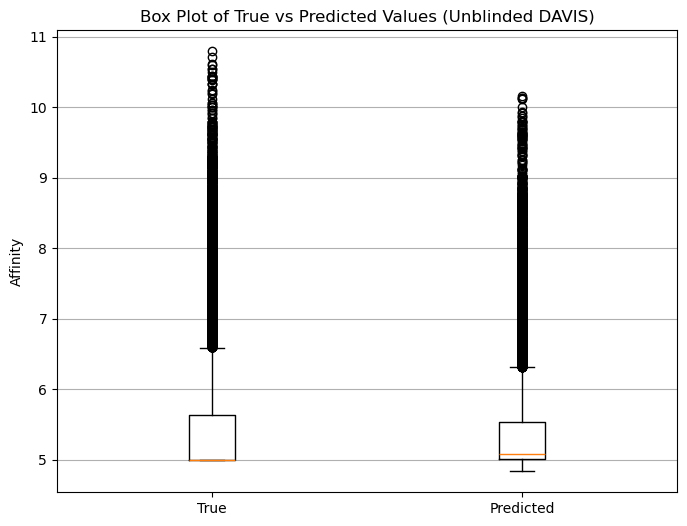

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "new/crossval_predictions_GINConvNet_davis_b3.csv"
df = pd.read_csv(file_path)

# Create box plots
plt.figure(figsize=(8, 6))
plt.boxplot([df["True_Label"], df["Predicted_Value"]], labels=["True", "Predicted"])

plt.title("Box Plot of True vs Predicted Values (Unblinded DAVIS)")
plt.ylabel("Affinity")
plt.grid(axis='y')
plt.show()


Mean Squared Error (MSE): 0.221
Mean Absolute Error (MAE): 0.259
R² Score: 0.736
Spearman Correlation: 0.730
Pearson Correlation: 0.860


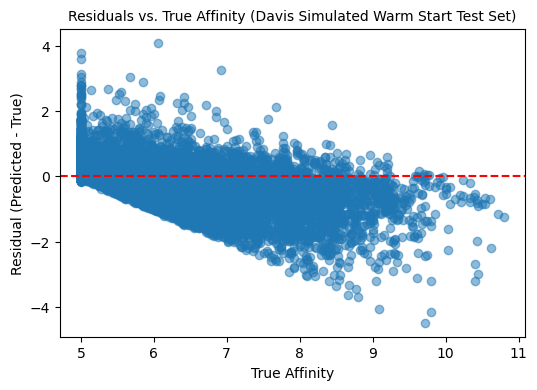

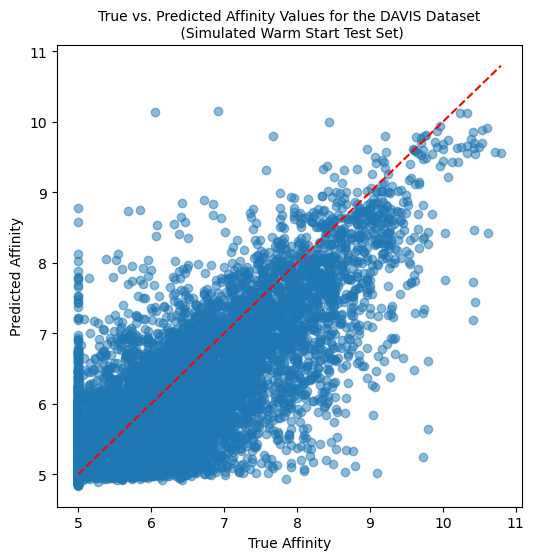

In [28]:
plot("new/crossval_predictions_GINConvNet_davis_b3.csv", "True vs. Predicted Affinity Values for the DAVIS Dataset\n (Simulated Warm Start Test Set)", "Residuals vs. True Affinity (Davis Simulated Warm Start Test Set)")

In [29]:
import pandas as pd
import numpy as np
from collections import defaultdict

# List of file paths
file_paths = [f"new/final_test_predictions_GINConvNet_davis_b3_{i}.csv" for i in range(1, 6)]

# Store predictions per triplet
prediction_dict = defaultdict(list)

for i, path in enumerate(file_paths, start=1):
    df = pd.read_csv(path)
    df.drop(columns=["Fold"], errors="ignore", inplace=True)
    df["Fold"] = i  # Add repeat index
    print(f"File {i}: {path} — {len(df)} rows")
    print(df.head(1))

    # Accumulate predictions for each triplet
    for _, row in df.iterrows():
        key = (row["Drug_ID"], row["Protein_ID"], row["True_Label"])
        prediction_dict[key].append((row["Predicted_Value"], i))  # Store fold info too

# Aggregate predictions
rows = []
for (d_id, p_id, true), values in prediction_dict.items():
    preds, folds = zip(*values)
    avg_pred = np.mean(preds)
    contributing_folds = ",".join(map(str, sorted(set(folds))))
    rows.append({
        "Drug_ID": d_id,
        "Protein_ID": p_id,
        "True_Label": true,
        "Predicted_Value": avg_pred,
        "Fold": contributing_folds  # You can keep as comma-separated string
    })

# Create final DataFrame
final_df = pd.DataFrame(rows)

# Save to file
output_path = "new/concatenated_final_test_predictions.csv"
final_df.to_csv(output_path, index=False)
concatenated_df = final_df
print(f"Saved aggregated predictions with Fold info to {output_path}")


File 1: new/final_test_predictions_GINConvNet_davis_b3_1.csv — 5712 rows
    Drug_ID Protein_ID  True_Label  Predicted_Value  Fold
0  10138260      SNARK     6.39794         5.411871     1
File 2: new/final_test_predictions_GINConvNet_davis_b3_2.csv — 5508 rows
    Drug_ID Protein_ID  True_Label  Predicted_Value  Fold
0  10427712        TXK         5.0         4.936027     2
File 3: new/final_test_predictions_GINConvNet_davis_b3_3.csv — 7072 rows
   Drug_ID Protein_ID  True_Label  Predicted_Value  Fold
0  6450551       GRK1         5.0         4.977173     3
File 4: new/final_test_predictions_GINConvNet_davis_b3_4.csv — 6256 rows
    Drug_ID Protein_ID  True_Label  Predicted_Value  Fold
0  11427553       ERK1         5.0         5.762062     4
File 5: new/final_test_predictions_GINConvNet_davis_b3_5.csv — 5508 rows
   Drug_ID Protein_ID  True_Label  Predicted_Value  Fold
0   208908      PRKCI         5.0         4.847114     5
Saved aggregated predictions with Fold info to new/concaten

In [30]:
import matplotlib.pyplot as plt

def plot_true_vs_predicted_by_fold(df, true_col="True_Label", pred_col="Predicted_Value", fold_col="Fold"):
    """
    Plots True vs Predicted values colored by fold.

    Parameters:
    - df: DataFrame containing the data
    - true_col: Column name for true labels
    - pred_col: Column name for predicted values
    - fold_col: Column name indicating the fold number
    """
    unique_folds = sorted(df[fold_col].unique())
    cmap = plt.get_cmap("tab10")  # Use a categorical colormap

    plt.figure(figsize=(8, 6))
    
    for i, fold in enumerate(unique_folds):
        fold_data = df[df[fold_col] == fold]
        plt.scatter(fold_data[true_col], fold_data[pred_col],
                    label=f"Fold {fold}", color=cmap(i), alpha=0.6, edgecolors='k', linewidths=0.5)

    plt.plot([df[true_col].min(), df[true_col].max()],
             [df[true_col].min(), df[true_col].max()],
             color='gray', linestyle='--', linewidth=1.5, label="Ideal")

    plt.xlabel("True Label")
    plt.ylabel("Predicted Value")
    plt.title("True vs Predicted by Fold (BLINDED)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
import matplotlib.pyplot as plt
import math

def plot_true_vs_predicted_by_fold_grid(df, true_col="True_Label", pred_col="Predicted_Value", fold_col="Fold"):
    """
    Plots True vs Predicted values in separate subplots for each fold.

    Parameters:
    - df: DataFrame containing the data
    - true_col: Column name for true labels
    - pred_col: Column name for predicted values
    - fold_col: Column name indicating the fold number
    """
    unique_folds = sorted(df[fold_col].unique())
    n_folds = len(unique_folds)

    n_cols = math.ceil(math.sqrt(n_folds))
    n_rows = math.ceil(n_folds / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), squeeze=False)

    vmin = df[true_col].min()-.5
    vmax = df[true_col].max()+.5

    for idx, fold in enumerate(unique_folds):
        row, col = divmod(idx, n_cols)
        ax = axes[row][col]

        fold_data = df[df[fold_col] == fold]
        ax.scatter(fold_data[true_col], fold_data[pred_col],
                   alpha=0.6, edgecolors='k', linewidths=0.5, color='tab:blue', label=f"Fold {fold}")
        
        ax.plot([vmin, vmax], [vmin, vmax], 'r--', linewidth=1.2, label="Ideal")
        ax.set_title(f"Fold {fold}")
        ax.set_xlabel("True Label")
        ax.set_ylabel("Predicted Value")
        ax.set_xlim(vmin, vmax)
        ax.set_ylim(vmin, vmax)
        ax.grid(True)
        ax.legend()

    # Hide unused subplots
    for idx in range(n_folds, n_rows * n_cols):
        row, col = divmod(idx, n_cols)
        axes[row][col].axis('off')

    fig.suptitle("True vs Predicted per Fold (BLINDED)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def boxplot_true_vs_pred_by_fold(df, true_col="True_Label", pred_col="Predicted_Value", fold_col="Fold"):
    """
    Creates side-by-side box plots of true and predicted values per fold.
    
    Parameters:
    - df: DataFrame containing true labels, predicted values, and fold information
    - true_col: Name of the column with true labels
    - pred_col: Name of the column with predicted values
    - fold_col: Name of the column with fold identifiers
    """
    # Prepare the data for seaborn: long format
    melted = pd.melt(
        df,
        id_vars=[fold_col],
        value_vars=[true_col, pred_col],
        var_name="Type",
        value_name="Value"
    )
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=melted, x=fold_col, y="Value", hue="Type", palette="Set1", showfliers=True)

    plt.title("True vs Predicted Value Distributions per Fold (BLINDED)", fontsize=14)
    plt.xlabel("Fold")
    plt.ylabel("Value")
    plt.legend(title="Value Type")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()




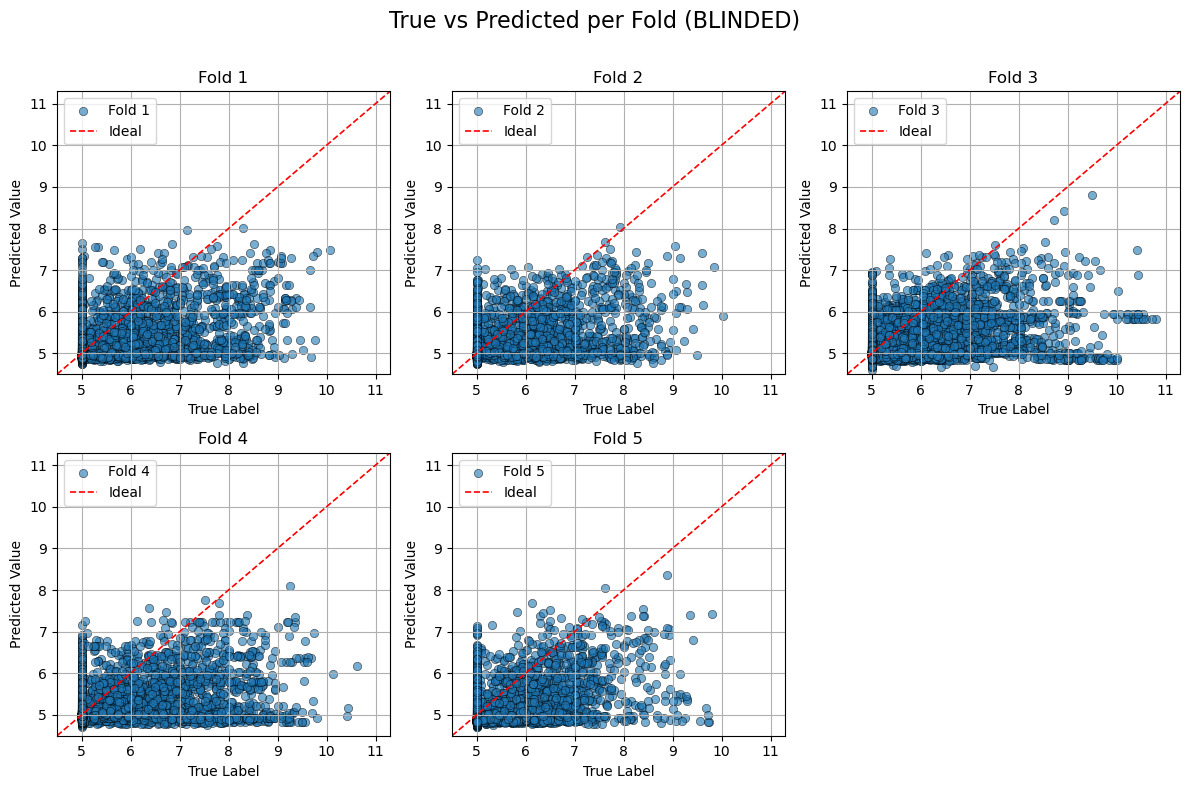

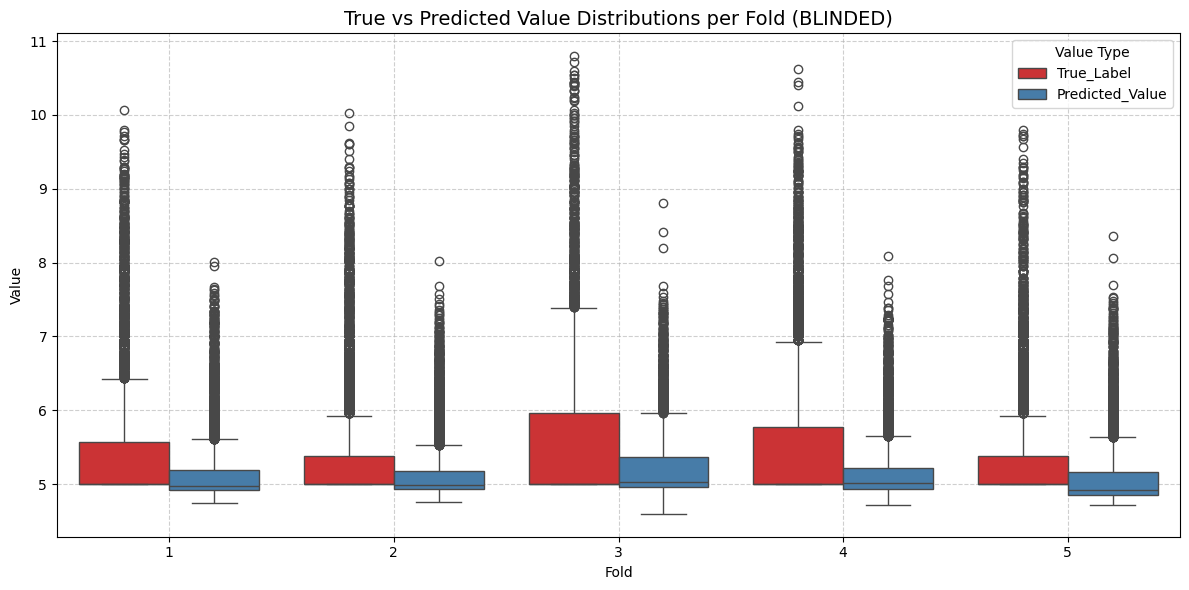

In [31]:
plot_true_vs_predicted_by_fold_grid(concatenated_df)
boxplot_true_vs_pred_by_fold(concatenated_df)

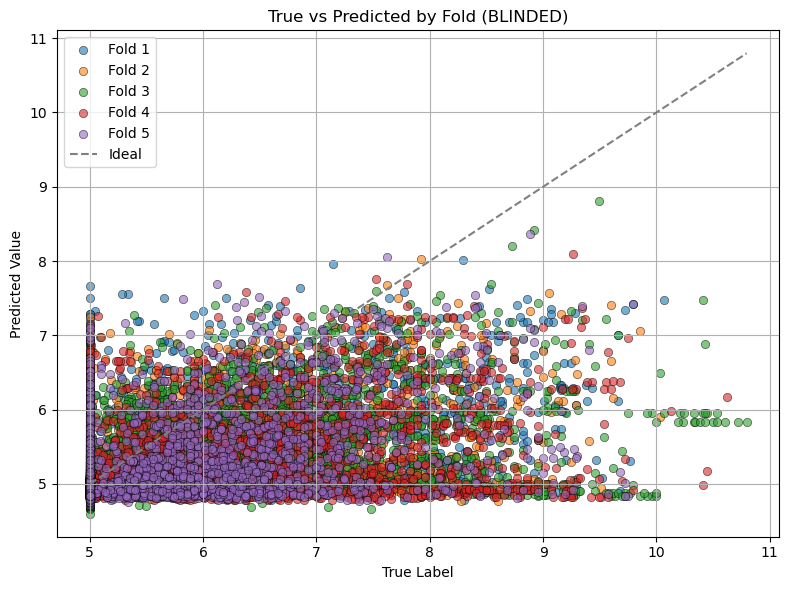

In [32]:
plot_true_vs_predicted_by_fold(concatenated_df)

Mean Squared Error (MSE): 0.734
Mean Absolute Error (MAE): 0.462
R² Score: 0.123
Spearman Correlation: 0.416
Pearson Correlation: 0.486


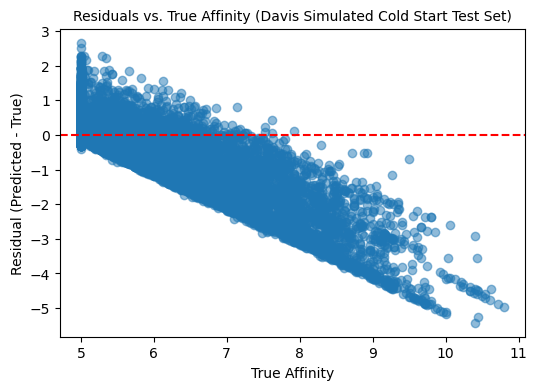

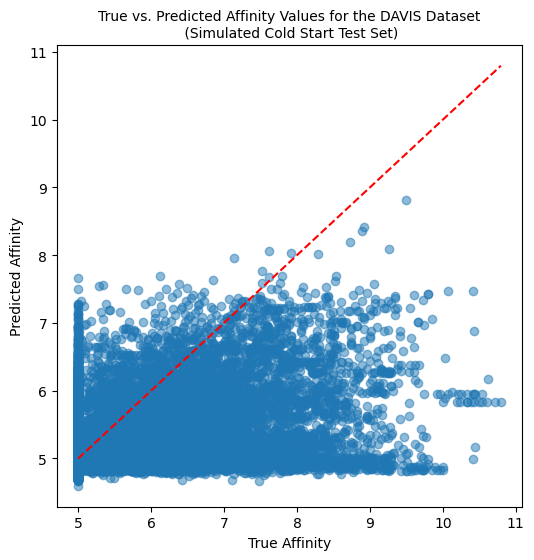

In [33]:
plot("new/concatenated_final_test_predictions.csv", "True vs. Predicted Affinity Values for the DAVIS Dataset\n (Simulated Cold Start Test Set)", "Residuals vs. True Affinity (Davis Simulated Cold Start Test Set)")

Mean Squared Error (MSE): 5.346
Mean Absolute Error (MAE): 2.193
R² Score: -10.378
Spearman Correlation: 0.180
Pearson Correlation: 0.118


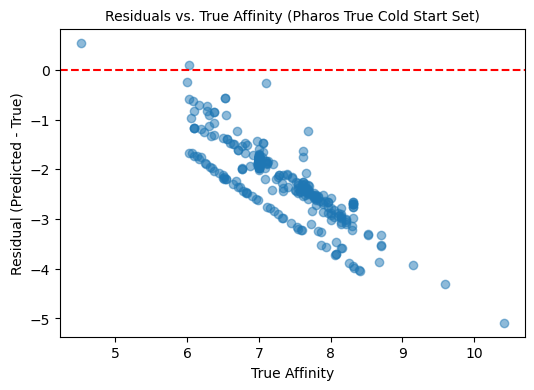

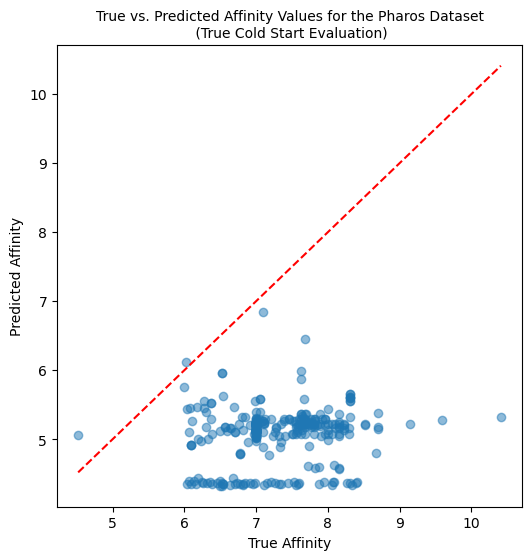

In [34]:
plot(
    "new/pharos_test_predictions_GINConvNet.csv",
    "True vs. Predicted Affinity Values for the Pharos Dataset\n (True Cold Start Evaluation)",
    "Residuals vs. True Affinity (Pharos True Cold Start Set)"
)


In [35]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_blinded_vs_unblinded(unblinded_file: str, blinded_file: str, save_path_prefix: str = None):
    """
    Compare predictions between unblinded and blinded datasets by matching Drug_ID and Protein_ID,
    and plot scatter and residual plots separately.

    Parameters
    ----------
    unblinded_file : str
        Path to the CSV file containing predictions on unblinded data.
    blinded_file : str
        Path to the CSV file containing predictions on blinded data.
    save_path_prefix : str, optional
        If provided, saves the two plots using this prefix. Example: 'comparison_plot' will save
        'comparison_plot_scatter.png' and 'comparison_plot_residual.png'.
    
    Returns
    -------
    None
    """
    unblinded_df = pd.read_csv(unblinded_file)
    blinded_df = pd.read_csv(blinded_file)

    print("Un:", len(unblinded_df))
    print(len(blinded_df))

    merged_df = pd.merge(
        unblinded_df,
        blinded_df,
        on=["Drug_ID", "Protein_ID", "True_Label"],
        suffixes=("_unblinded", "_blinded")
    )
    print("Merged:", len(merged_df))

    # Residuals
    merged_df["Residual"] = merged_df["Predicted_Value_blinded"] - merged_df["Predicted_Value_unblinded"]

    # === Stats ===
    overall_stats = {
        "Mean_Difference": merged_df["Residual"].mean(),
        "Max_Difference": merged_df["Residual"].max(),
        "Min_Difference": merged_df["Residual"].min(),
        "Average_Positive_Difference": merged_df[merged_df["Residual"] > 0]["Residual"].mean(),
        "Average_Negative_Difference": merged_df[merged_df["Residual"] < 0]["Residual"].mean(),
        "Count_Positive_Differences": (merged_df["Residual"] > 0).sum(),
        "Count_Negative_Differences": (merged_df["Residual"] < 0).sum(),
    }

    print("Overall Statistics for Residuals (Blinded - Unblinded):")
    for stat, value in overall_stats.items():
        print(f"{stat}: {value:.4f}")

    # === Scatter Plot ===
    plt.figure(figsize=(7, 6))
    plt.scatter(
        merged_df["Predicted_Value_unblinded"],
        merged_df["Predicted_Value_blinded"],
        alpha=0.6,
        #edgecolors='w',
        linewidths=0.5
    )
    plt.plot(
        [merged_df["Predicted_Value_unblinded"].min(), merged_df["Predicted_Value_unblinded"].max()],
        [merged_df["Predicted_Value_unblinded"].min(), merged_df["Predicted_Value_unblinded"].max()],
        'r--', label='y = x'
    )
    plt.xlabel("Simulated Warm Start Predicted Value")
    plt.ylabel("Simulated Cold Start Predicted Value")
    plt.title("Simulated Cold vs. Warm Start Predictions")
    plt.legend()
    plt.grid(True)
    if save_path_prefix:
        plt.savefig(f"{save_path_prefix}_scatter.png", bbox_inches='tight')
        print(f"Scatter plot saved to {save_path_prefix}_scatter.png")
    else:
        plt.show()

    # === Residual Plot ===
    plt.figure(figsize=(7, 5))
    plt.scatter(
        merged_df["Predicted_Value_unblinded"],
        merged_df["Residual"],
        alpha=0.6,
        #edgecolors='w',
        linewidths=0.5
    )
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.xlabel("Unblinded Predicted Value")
    plt.ylabel("Residual (Blinded - Unblinded)")
    plt.title("Residual (Blinded - Unblinded) Plot")
    plt.grid(True)
    if save_path_prefix:
        plt.savefig(f"{save_path_prefix}_residual.png", bbox_inches='tight')
        print(f"Residual plot saved to {save_path_prefix}_residual.png")
    else:
        plt.show()


Un: 27621
27621
Merged: 27621
Overall Statistics for Residuals (Blinded - Unblinded):
Mean_Difference: -0.2608
Max_Difference: 2.3357
Min_Difference: -4.9491
Average_Positive_Difference: 0.2336
Average_Negative_Difference: -0.4307
Count_Positive_Differences: 7065.0000
Count_Negative_Differences: 20556.0000


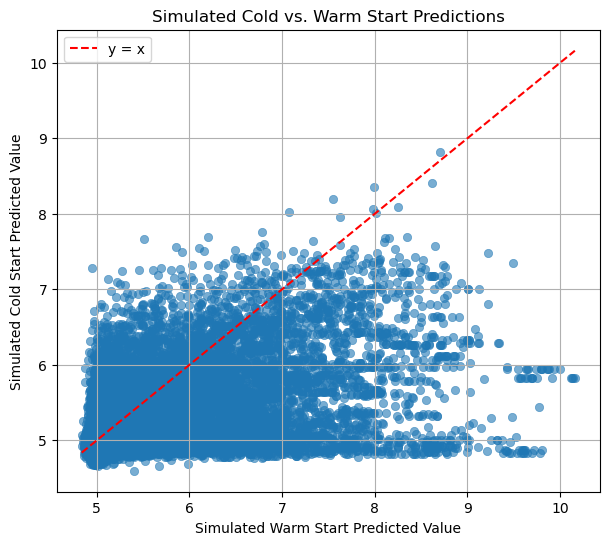

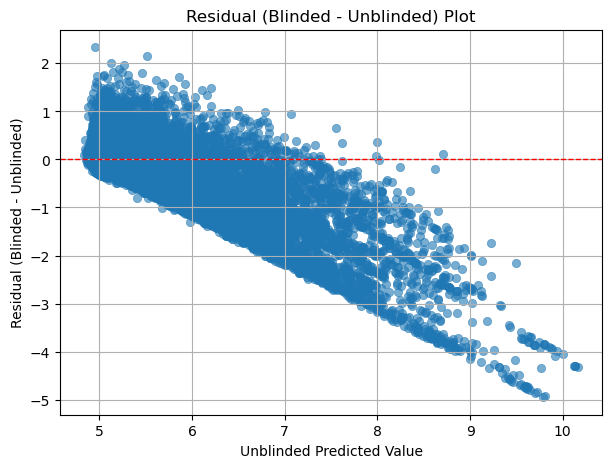

In [36]:
plot_blinded_vs_unblinded("new/crossval_predictions_GINConvNet_davis_b3.csv", "new/concatenated_final_test_predictions.csv")

In [37]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats
import matplotlib.pyplot as plt

def plot_multiple_predictions(prediction_dict: dict):
    """
    Plots true vs predicted values and residuals for multiple prediction files.

    Parameters
    ----------
    prediction_dict : dict
        Dictionary mapping labels (str) to file paths (str).
        Example: {"GIN": "gin_preds.csv", "GAT": "gat_preds.csv"}
    """
    plt.figure(figsize=(6, 6))
    for label, file_path in prediction_dict.items():
        df = pd.read_csv(file_path)
        y_true = df["True_Label"].values
        y_pred = df["Predicted_Value"].values

        # Regression metrics
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        pearson_corr, _ = stats.pearsonr(y_true.flatten(), y_pred.flatten())
        spearman_corr, _ = stats.spearmanr(y_true.flatten(), y_pred.flatten())

        print(f"=== {label} ===")
        print(f"Mean Squared Error (MSE): {mse:.3f}")
        print(f"Mean Absolute Error (MAE): {mae:.3f}")
        print(f"R² Score: {r2:.3f}")
        print(f"Spearman Correlation: {spearman_corr:.3f}")
        print(f"Pearson Correlation: {pearson_corr:.3f}")
        print()

        # Plot true vs predicted
        plt.scatter(y_true, y_pred, alpha=0.3, s=10, edgecolors='k', linewidths=0.2, label=label)

    # Identity line
    min_val, max_val = plt.xlim()
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

    plt.xlabel("True Affinity")
    plt.ylabel("Predicted Affinity")
    plt.title("True vs Predicted Affinities")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Residual plots
    plt.figure(figsize=(6, 4))
    for label, file_path in prediction_dict.items():
        df = pd.read_csv(file_path)
        y_true = df["True_Label"].values
        y_pred = df["Predicted_Value"].values
        residuals = y_pred - y_true

        plt.scatter(y_true, residuals, alpha=0.3, s=10, edgecolors='k', linewidths=0.2, label=label)

    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("True Affinity")
    plt.ylabel("Residual (Predicted - True)")
    plt.title("Residuals of Predictions")
    plt.legend()
    plt.grid(True)
    plt.show()


=== Unblinded ===
Mean Squared Error (MSE): 0.221
Mean Absolute Error (MAE): 0.259
R² Score: 0.736
Spearman Correlation: 0.730
Pearson Correlation: 0.860

=== Blinded ===
Mean Squared Error (MSE): 0.734
Mean Absolute Error (MAE): 0.462
R² Score: 0.123
Spearman Correlation: 0.416
Pearson Correlation: 0.486

=== Pharos ===
Mean Squared Error (MSE): 5.346
Mean Absolute Error (MAE): 2.193
R² Score: -10.378
Spearman Correlation: 0.180
Pearson Correlation: 0.118



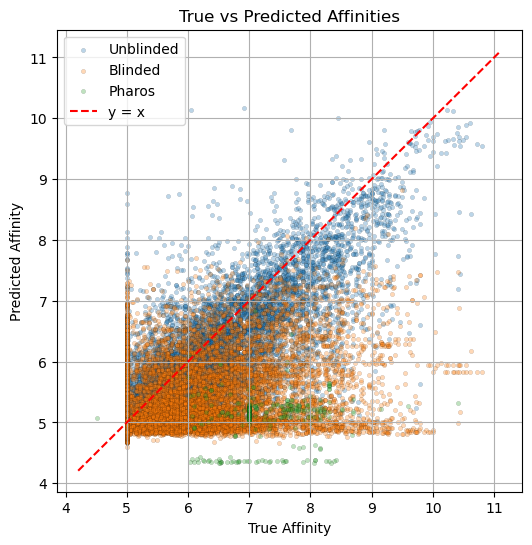

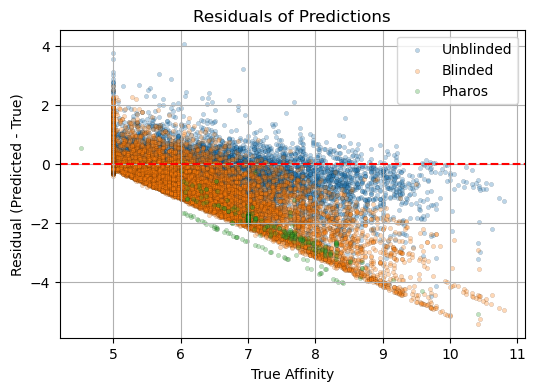

In [38]:
files = [
    "new/crossval_predictions_GINConvNet_davis_b3.csv",
    "new/concatenated_final_test_predictions.csv",
    "new/pharos_test_predictions_GINConvNet.csv"
]
labels = ["Unblinded", "Blinded", "Pharos"]

# Construct dictionary mapping labels to file paths
prediction_dict = dict(zip(labels, files))

# Now call the updated function
plot_multiple_predictions(prediction_dict)

# Metrics

In [39]:
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull, Delaunay
from scipy.stats import gaussian_kde
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv

def load_xy(file):
    df = pd.read_csv(file)
    x = df["True_Label"].values
    y = df["Predicted_Value"].values
    return np.column_stack((x, y))

def mahalanobis_distances(blinded, unblinded):
    cov = np.cov(unblinded.T)
    cov_inv = inv(cov)
    mean = np.mean(unblinded, axis=0)
    dists = [mahalanobis(x, mean, cov_inv) for x in blinded]
    return dists

def kde_likelihoods(blinded, unblinded):
    kde = gaussian_kde(unblinded.T)
    likelihoods = kde.pdf(blinded.T)
    return likelihoods

def convex_hull_fraction(blinded, unblinded):
    hull = ConvexHull(unblinded)
    delaunay = Delaunay(unblinded[hull.vertices])
    inside = delaunay.find_simplex(blinded) >= 0
    return np.mean(inside), inside 

# File paths
unblinded_file = "new/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "new/concatenated_final_test_predictions.csv"
pharos_file = "new/pharos_test_predictions_GINConvNet.csv"

unblinded = load_xy(unblinded_file)
blinded = load_xy(blinded_file)
pharos = load_xy(pharos_file)

print("mahalanobis: how far a point is from the center of a distribution")
print("KDE estimates density of the unblinded distribution in the space and likelihood tells us how likely the unblinded points are under that distribution")
print("\nUNBLINDED DAVIS & UNBLINDED DAVIS")
maha_dists = mahalanobis_distances(unblinded, unblinded)
print(f"Mean Mahalanobis Distance: {np.mean(maha_dists):.3f}")
likelihoods = kde_likelihoods(unblinded, unblinded)
print(f"Mean KDE Likelihood: {np.mean(likelihoods):.3e}")


print("\nBLINDED DAVIS & UNBLINDED DAVIS")
maha_dists = mahalanobis_distances(blinded, unblinded)
print(f"Mean Mahalanobis Distance: {np.mean(maha_dists):.3f}")
likelihoods = kde_likelihoods(blinded, unblinded)
print(f"Mean KDE Likelihood: {np.mean(likelihoods):.3e}")


print("\nPHAROS & UNBLINDED DAVIS")
maha_dists = mahalanobis_distances(pharos, unblinded)
print(f"Mean Mahalanobis Distance: {np.mean(maha_dists):.3f}")
likelihoods = kde_likelihoods(pharos, unblinded)
print(f"Mean KDE Likelihood: {np.mean(likelihoods):.3e}")


mahalanobis: how far a point is from the center of a distribution
KDE estimates density of the unblinded distribution in the space and likelihood tells us how likely the unblinded points are under that distribution

UNBLINDED DAVIS & UNBLINDED DAVIS
Mean Mahalanobis Distance: 1.042
Mean KDE Likelihood: 2.985e+00

BLINDED DAVIS & UNBLINDED DAVIS
Mean Mahalanobis Distance: 1.340
Mean KDE Likelihood: 2.305e+00

PHAROS & UNBLINDED DAVIS
Mean Mahalanobis Distance: 4.683
Mean KDE Likelihood: 9.536e-03


DAVIS: Fraction Inside: 0.929, Mean Outside Distance: 0.0469, Max: 0.8175


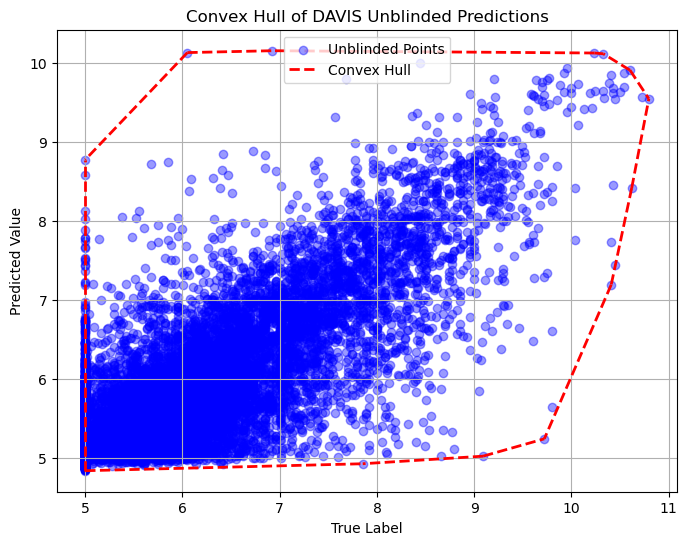

PHAROS: Fraction Inside: 0.787, Mean Outside Distance: 0.4653, Max: 0.6232


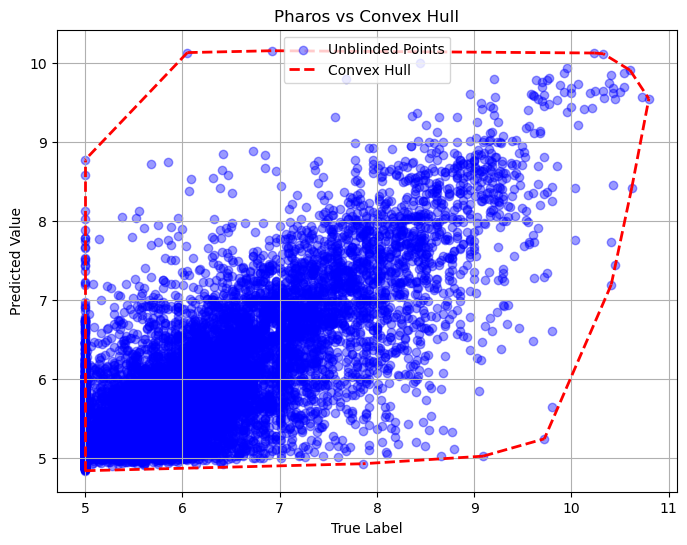

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, Delaunay
from shapely.geometry import Polygon, Point
from shapely.ops import nearest_points

def distance_outside_convex_hull(blinded, unblinded, inside_mask):
    # Create shapely polygon from hull vertices
    hull = ConvexHull(unblinded)
    polygon = Polygon(unblinded[hull.vertices])

    outside_points = blinded[~inside_mask]
    distances = []
    for pt in outside_points:
        p = Point(pt)
        nearest_geom = nearest_points(p, polygon.boundary)[1]
        distances.append(p.distance(nearest_geom))
    
    return distances, outside_points

def plot_convex_hull(unblinded, blinded, title="Convex Hull Containment", highlight_outside=False, outside_points=None):
    hull = ConvexHull(unblinded)
    plt.figure(figsize=(8, 6))
    
    # Unblinded in blue
    plt.scatter(unblinded[:, 0], unblinded[:, 1], c='blue', alpha=0.4, label="Unblinded Points")

    # Convex hull
    for i, simplex in enumerate(hull.simplices):
        if i == 0:
            plt.plot(unblinded[simplex, 0], unblinded[simplex, 1], 'r--', linewidth=2, label="Convex Hull")
        else:
            plt.plot(unblinded[simplex, 0], unblinded[simplex, 1], 'r--', linewidth=2)


    # # Blinded in green
    # plt.scatter(blinded[:, 0], blinded[:, 1], c='green', alpha=0.6, label="Blinded Points")

    # # Highlight points outside convex hull in red if desired
    # if highlight_outside and outside_points is not None:
    #     plt.scatter(outside_points[:, 0], outside_points[:, 1], c='red', alpha=0.7, label="Outside Points", marker='x')

    plt.xlabel("True Label")
    plt.ylabel("Predicted Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# File paths
unblinded_file = "new/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "new/concatenated_final_test_predictions.csv"
pharos_file = "new/pharos_test_predictions_GINConvNet.csv"

unblinded = load_xy(unblinded_file)
blinded = load_xy(blinded_file)
pharos = load_xy(pharos_file)

# For DAVIS blinded
frac_inside, inside_mask = convex_hull_fraction(blinded, unblinded)
distances, outside_pts = distance_outside_convex_hull(blinded, unblinded, inside_mask)
print(f"DAVIS: Fraction Inside: {frac_inside:.3f}, Mean Outside Distance: {np.mean(distances):.4f}, Max: {np.max(distances):.4f}")
plot_convex_hull(unblinded, blinded, "Convex Hull of DAVIS Unblinded Predictions", highlight_outside=True, outside_points=outside_pts)

# For PHAROS blinded
frac_inside_p, inside_mask_p = convex_hull_fraction(pharos, unblinded)
distances_p, outside_pts_p = distance_outside_convex_hull(pharos, unblinded, inside_mask_p)
print(f"PHAROS: Fraction Inside: {frac_inside_p:.3f}, Mean Outside Distance: {np.mean(distances_p):.4f}, Max: {np.max(distances_p):.4f}")
plot_convex_hull(unblinded, pharos, "Pharos vs Convex Hull", highlight_outside=True, outside_points=outside_pts_p)

27621


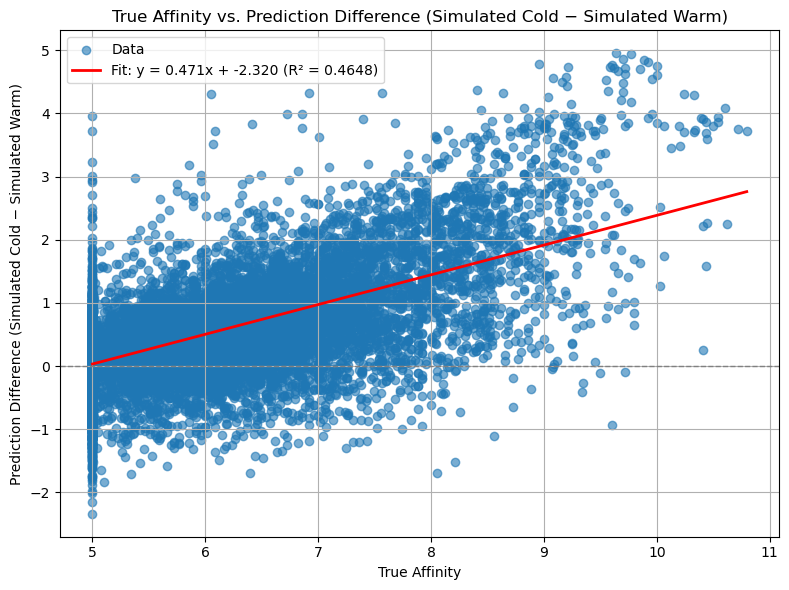

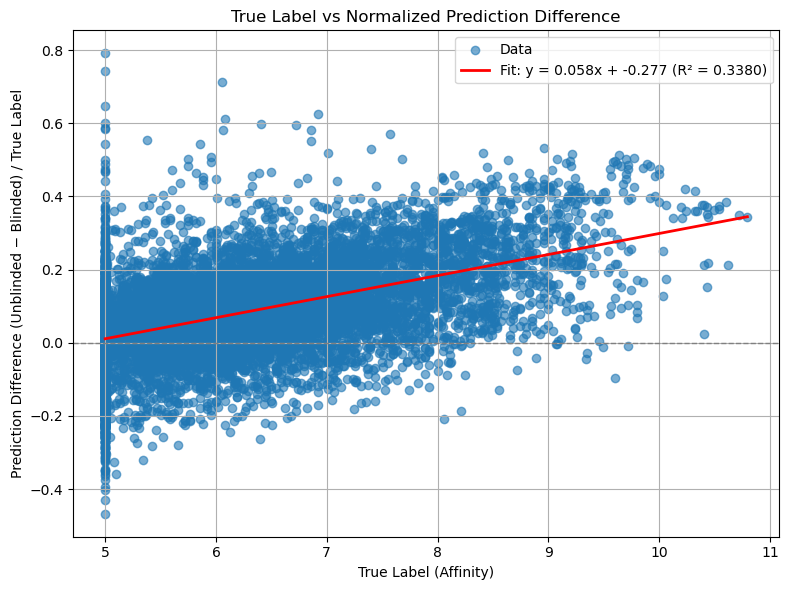

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# File paths
unblinded_file = "new/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "new/concatenated_final_test_predictions.csv"

# Load both files
df_unblinded = pd.read_csv(unblinded_file)
df_blinded = pd.read_csv(blinded_file)

# Rename prediction columns to distinguish
df_unblinded = df_unblinded.rename(columns={"Predicted_Value": "Unblinded_Prediction"})
df_blinded = df_blinded.rename(columns={"Predicted_Value": "Blinded_Prediction"})

# Merge on Drug_ID and Protein_ID
merged_df = pd.merge(
    df_unblinded[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    df_blinded[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)
print(len(merged_df))

# --- Plot 1: Raw Difference ---
merged_df["Prediction_Diff"] = merged_df["Unblinded_Prediction"] - merged_df["Blinded_Prediction"]

x = merged_df["True_Label"]
y = merged_df["Prediction_Diff"]
coeffs = np.polyfit(x, y, deg=1)
poly_eq = np.poly1d(coeffs)
y_pred = poly_eq(x)
r_squared = r2_score(y, y_pred)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6, label="Data")
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = poly_eq(x_fit)
plt.plot(x_fit, y_fit, color='red', linewidth=2,
         label=f"Fit: y = {coeffs[0]:.3f}x + {coeffs[1]:.3f} (R² = {r_squared:.4f})")

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("True Affinity")
plt.ylabel("Prediction Difference (Simulated Cold − Simulated Warm)")
plt.title("True Affinity vs. Prediction Difference (Simulated Cold − Simulated Warm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Normalized Difference ---
merged_df["Prediction_Diff"] = (
    merged_df["Unblinded_Prediction"] - merged_df["Blinded_Prediction"]
) / merged_df["True_Label"]

x = merged_df["True_Label"]
y = merged_df["Prediction_Diff"]
coeffs_norm = np.polyfit(x, y, deg=1)
poly_eq_norm = np.poly1d(coeffs_norm)
y_pred_norm = poly_eq_norm(x)
r_squared_norm = r2_score(y, y_pred_norm)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6, label="Data")
y_fit_norm = poly_eq_norm(x_fit)
plt.plot(x_fit, y_fit_norm, color='red', linewidth=2,
         label=f"Fit: y = {coeffs_norm[0]:.3f}x + {coeffs_norm[1]:.3f} (R² = {r_squared_norm:.4f})")

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("True Label (Affinity)")
plt.ylabel("Prediction Difference (Unblinded − Blinded) / True Label")
plt.title("True Label vs Normalized Prediction Difference")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


As the true affinity increases, the relative difference between unblinded and blinded predictions also increases. The bias introduced by blinding is not uniform across the affinity spectrum—it’s worse for high-affinity targets.

Now make a metric/ vulnerability score

LOOKING AT DUPLICATES / OVERLAPS

In [42]:
import pandas as pd

# Load the CSVs
crossval_df = pd.read_csv("new/crossval_predictions_GINConvNet_davis_b3.csv")
final_df = pd.read_csv("new/concatenated_final_test_predictions.csv")

# Extract (Drug_ID, Protein_ID) pairs as sets
crossval_pairs = set(zip(crossval_df["Drug_ID"], crossval_df["Protein_ID"]))
final_pairs = set(zip(final_df["Drug_ID"], final_df["Protein_ID"]))

# Pairs in crossval but not in final
missing_in_final = crossval_pairs - final_pairs

# Pairs in final but not in crossval
missing_in_crossval = final_pairs - crossval_pairs

print(f"Number of pairs in crossval but not in final: {len(missing_in_final)}")
print(f"Number of pairs in final but not in crossval: {len(missing_in_crossval)}")

# Optionally: print a few missing pairs for inspection
print("Sample missing in final:", list(missing_in_final)[:5])
print("Sample missing in crossval:", list(missing_in_crossval)[:5])


# Check for duplicates
crossval_duplicates = crossval_df.duplicated(subset=["Drug_ID", "Protein_ID"], keep=False)
final_duplicates = final_df.duplicated(subset=["Drug_ID", "Protein_ID", "True_Label"], keep=False)

print(f"Number of duplicate pairs in crossval: {crossval_duplicates.sum()}")
print(f"Number of duplicate pairs in final: {final_duplicates.sum()}")


print("\nSample duplicates in final:")
print(final_df[final_duplicates].head())

duplicate_proteins_final = final_df.loc[final_duplicates, "Protein_ID"].unique()

print("\nProtein_IDs with duplicates in final:")
print(duplicate_proteins_final)


Number of pairs in crossval but not in final: 0
Number of pairs in final but not in crossval: 0
Sample missing in final: []
Sample missing in crossval: []
Number of duplicate pairs in crossval: 2395
Number of duplicate pairs in final: 0

Sample duplicates in final:
Empty DataFrame
Columns: [Drug_ID, Protein_ID, True_Label, Predicted_Value, Fold]
Index: []

Protein_IDs with duplicates in final:
[]


See yes theres duplicates in some split files but its bc theres also overlap between the train and test splits created by the models train/test folds

In [43]:
import pandas as pd

train_df = pd.read_csv('../../data/davis_train.csv')
test_df = pd.read_csv('../../data/davis_test.csv')

# Create sets of (drug, protein) tuples
train_pairs = set(zip(train_df['compound_iso_smiles'], train_df['target_sequence'], train_df['affinity']))
test_pairs = set(zip(test_df['compound_iso_smiles'], test_df['target_sequence'], train_df['affinity']))

# Find intersection
overlapping_pairs = train_pairs.intersection(test_pairs)
print(f"Number of overlapping (drug, protein, affinity) pairs: {len(overlapping_pairs)}")

if overlapping_pairs:
    print("\nSample overlapping pairs:")
    print(list(overlapping_pairs)[:5])


Number of overlapping (drug, protein, affinity) pairs: 314

Sample overlapping pairs:
[('Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S(N)(=O)=O', 'MPLAQLKEPWPLMELVPLDPENGQTSGEEAGLQPSKDEGVLKEISITHHVKAGSEKADPSHFELLKVLGQGSFGKVFLVRKVTRPDSGHLYAMKVLKKATLKVRDRVRTKMERDILADVNHPFVVKLHYAFQTEGKLYLILDFLRGGDLFTRLSKEVMFTEEDVKFYLAELALGLDHLHSLGIIYRDLKPENILLDEEGHIKLTDFGLSKEAIDHEKKAYSFCGTVEYMAPEVVNRQGHSHSADWWSYGVLMFEMLTGSLPFQGKDRKETMTLILKAKLGMPQFLSTEAQSLLRALFKRNPANRLGSGPDGAEEIKRHVFYSTIDWNKLYRREIKPPFKPAVAQPDDTFYFDTEFTSRTPKDSPGIPPSAGAHQLFRGFSFVATGLMEDDGKPRAPQAPLHSVVQQLHGKNLVFSDGYVVKETIGVGSYSECKRCVHKATNMEYAVKVIDKSKRDPSEEIEILLRYGQHPNIITLKDVYDDGKHVYLVTELMRGGELLDKILRQKFFSEREASFVLHTIGKTVEYLHSQGVVHRDLKPSNILYVDESGNPECLRICDFGFAKQLRAENGLLMTPCYTANFVAPEVLKRQGYDEGCDIWSLGILLYTMLAGYTPFANGPSDTPEEILTRIGSGKFTLSGGNWNTVSETAKDLVSKMLHVDPHQRLTAKQVLQHPWVTQKDKLPQSQLSHQDLQLVKGAMAATYSALNSSKPTPQLKPIESSILAQRRVRKLPSTTL', 5.0), ('Cn1cc(-c2ccc3nnc(Sc4ccc5ncccc5c4)n3n2)cn1', 'TRALPEDAGEYTCLAGNSIGFSHHSAWLVVLPAEEELVEADEAGSVYAGILSYGVGFFLFI

# METRIC

Look at defining convex hull per protien/ per affinity

In [44]:
def compute_CHR_per_protein(merged_df):
    #based on convex hull:  how often the model predicts out-of-distribution values when faced with a cold-start protein.
    CHR_dict = {}

    for protein_id, group in merged_df.groupby("Protein_ID"):
        points_unblinded = group[["True_Label", "Unblinded_Prediction"]].values
        points_blinded = group[["True_Label", "Blinded_Prediction"]].values

        if len(points_unblinded) < 3:
            continue  # Need at least 3 points for a convex hull

        try:
            hull = ConvexHull(points_unblinded)
            polygon = Polygon(points_unblinded[hull.vertices])

            inside_mask = np.array([polygon.contains(Point(p)) for p in points_blinded])
            outside_count = (~inside_mask).sum()
            CHR = outside_count / len(points_blinded)
            CHR_dict[protein_id] = CHR
        except:
            continue  # Handle degenerate geometry

    return pd.Series(CHR_dict)


def compute_CSPD_per_protein(merged_df):
    #how much a model’s prediction changes for the same input when the protein is blinded
    merged_df["NPD"] = (
        merged_df["Unblinded_Prediction"] - merged_df["Blinded_Prediction"]
    ) / merged_df["True_Label"]

    CSPD = merged_df.groupby("Protein_ID")["NPD"].mean()
    return CSPD.rename("CSPD")


def compute_CSVS_protein_level(merged_df, alpha=None, beta=None):
    # Step 1: Get per-protein CSPD and CHR
    CSPD_per_protein = compute_CSPD_per_protein(merged_df)
    CHR_per_protein = compute_CHR_per_protein(merged_df)

    # Align proteins
    common_proteins = CSPD_per_protein.index.intersection(CHR_per_protein.index)
    CSPD = CSPD_per_protein.loc[common_proteins].abs()
    CHR = CHR_per_protein.loc[common_proteins]

    # Normalize weights if not provided
    if alpha is None:
        alpha = 1 / CSPD.max()
    if beta is None:
        beta = 1 / CHR.max()

    # Compute CSVS for each protein
    csvs_per_protein = alpha * CSPD + beta * CHR
    print(csvs_per_protein)

    # Return the protein-level CSVS (mean across proteins)
    csvs_model = csvs_per_protein.mean()
    return csvs_model, csvs_per_protein, alpha, beta



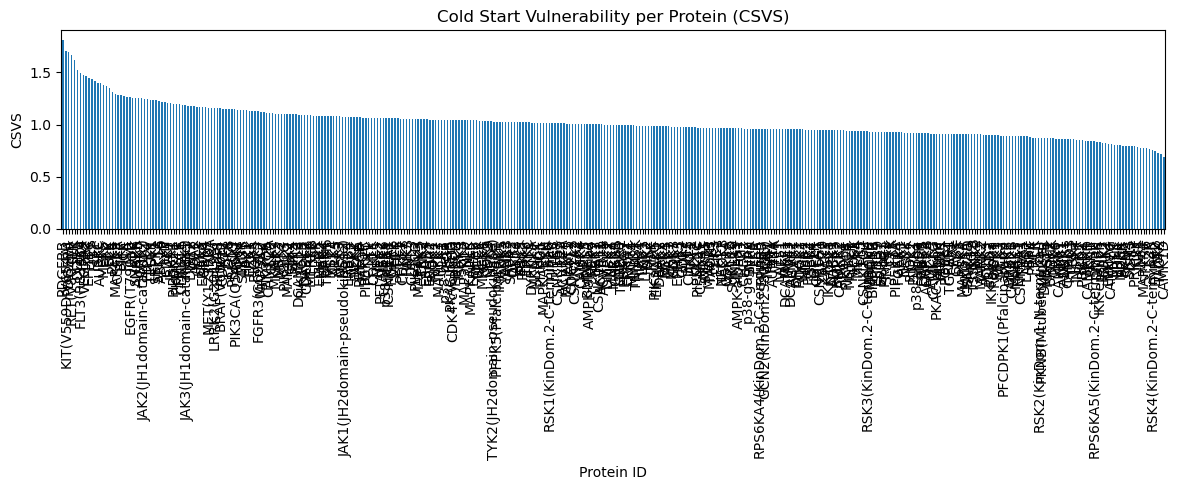

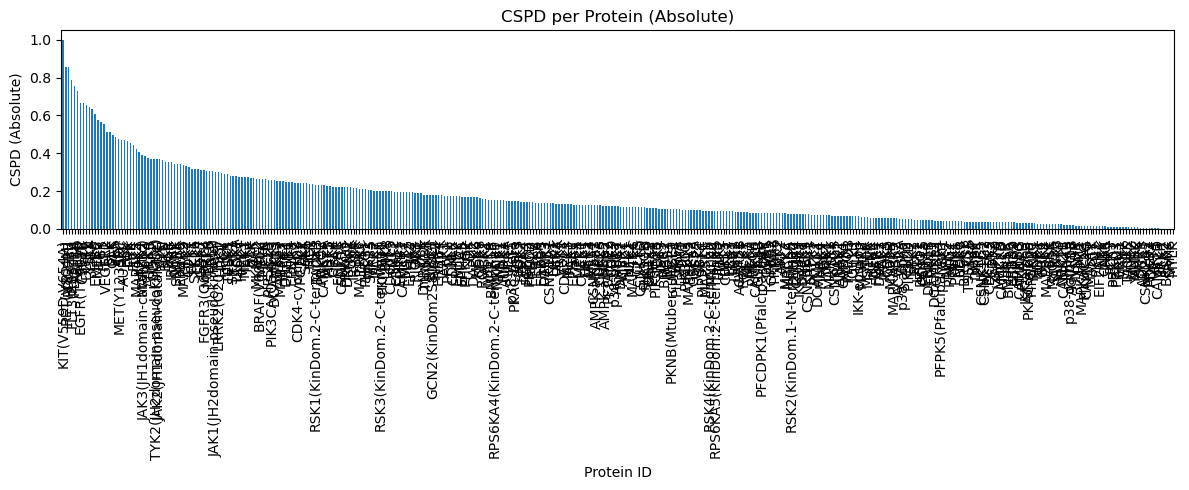

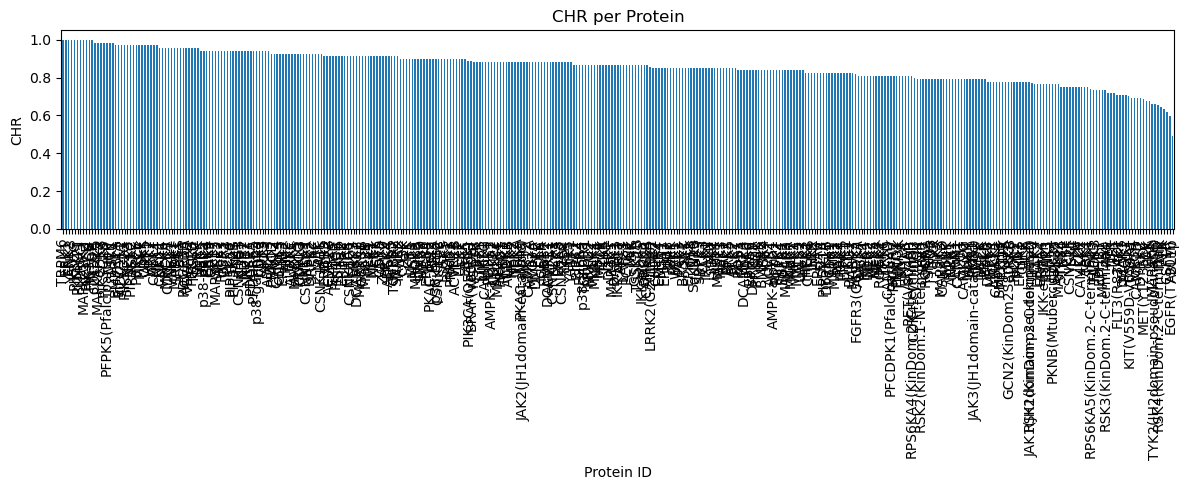

AAK1         0.925310
ABL1p        1.219273
ABL2         1.171596
ACVR1        0.955878
ACVR1B       0.916396
               ...   
ZAP70        0.948994
p38-alpha    0.920834
p38-beta     1.044967
p38-delta    1.062619
p38-gamma    0.962285
Length: 379, dtype: float64
Model-level CSVS: 1.0228
Alpha scaling: 4.5980, Beta scaling: 1.0000


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# File paths
unblinded_file = "new/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "new/concatenated_final_test_predictions.csv"

# Load both files
df_unblinded = pd.read_csv(unblinded_file)
df_blinded = pd.read_csv(blinded_file)

# Rename prediction columns to distinguish
df_unblinded = df_unblinded.rename(columns={"Predicted_Value": "Unblinded_Prediction"})
df_blinded = df_blinded.rename(columns={"Predicted_Value": "Blinded_Prediction"})

# Merge on Drug_ID and Protein_ID
merged_df = pd.merge(
    df_unblinded[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    df_blinded[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)

# Compute CSPD and CHR
CSPD_per_protein = compute_CSPD_per_protein(merged_df)
CSPD_abs = CSPD_per_protein.abs()
CHR_per_protein = compute_CHR_per_protein(merged_df)

# Normalize weights
alpha = 1 / CSPD_abs.max()
beta = 1 / CHR_per_protein.max()

# Combine into CSVS
csvs = alpha * CSPD_abs + beta * CHR_per_protein

# Plot CSVS
csvs.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5), title="Cold Start Vulnerability per Protein (CSVS)")
plt.ylabel("CSVS")
plt.xlabel("Protein ID")
plt.tight_layout()
plt.show()

# Plot CSPD
CSPD_abs_normalized = CSPD_abs*alpha
CSPD_abs_normalized.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5), title="CSPD per Protein (Absolute)")
plt.ylabel("CSPD (Absolute)")
plt.xlabel("Protein ID")
plt.tight_layout()
plt.show()

# Plot CHR
CHR_per_protein_normalized = CHR_per_protein*beta
CHR_per_protein_normalized.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5), title="CHR per Protein")
plt.ylabel("CHR")
plt.xlabel("Protein ID")
plt.tight_layout()
plt.show()

# Compute model-level CSVS
csvs_model, csvs_per_protein, alpha_used, beta_used = compute_CSVS_protein_level(merged_df)

print(f"Model-level CSVS: {csvs_model:.4f}")
print(f"Alpha scaling: {alpha_used:.4f}, Beta scaling: {beta_used:.4f}")


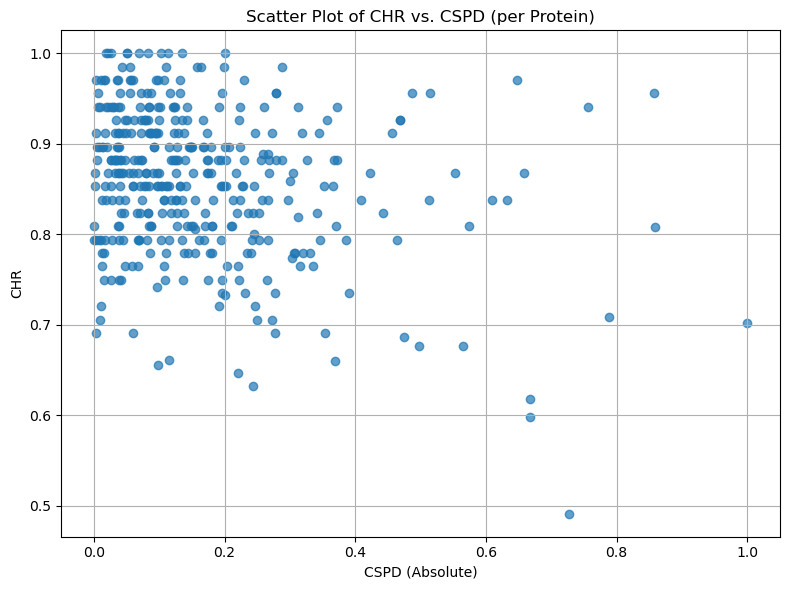

In [46]:
import matplotlib.pyplot as plt

# Ensure indices align
common_proteins = CSPD_abs.index.intersection(CHR_per_protein.index)
cspd_vals = CSPD_abs_normalized.loc[common_proteins]
chr_vals = CHR_per_protein_normalized.loc[common_proteins]

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(cspd_vals, chr_vals, alpha=0.7)

# Labeling
# for protein in common_proteins:
#     plt.annotate(protein, (cspd_vals[protein], chr_vals[protein]), fontsize=8, alpha=0.7)

plt.title("Scatter Plot of CHR vs. CSPD (per Protein)")
plt.xlabel("CSPD (Absolute)")
plt.ylabel("CHR")
plt.grid(True)
plt.tight_layout()
plt.show()


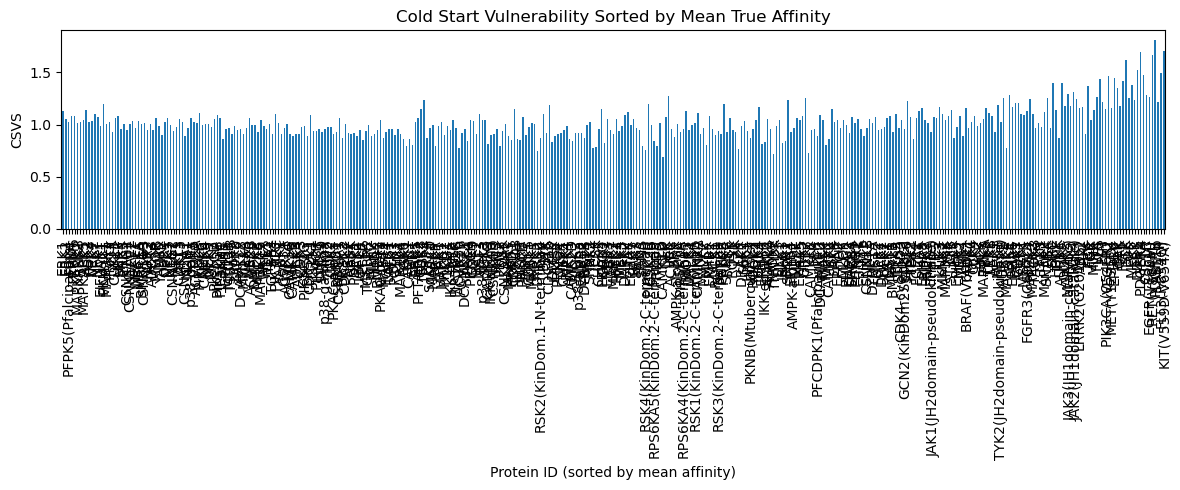

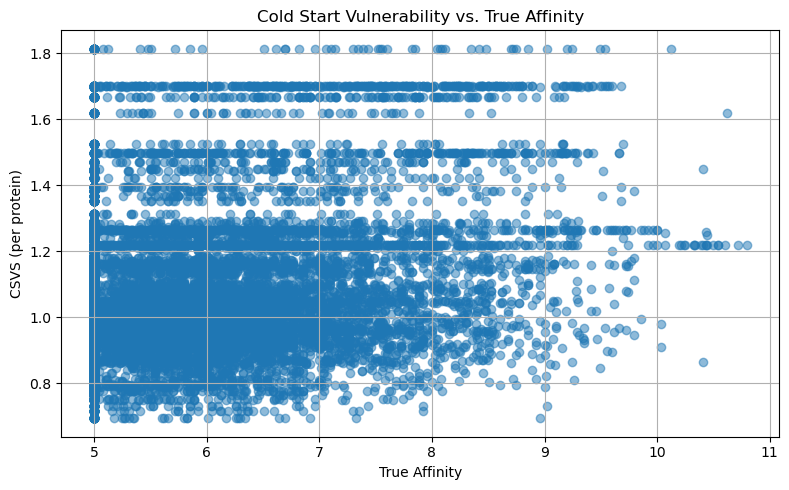

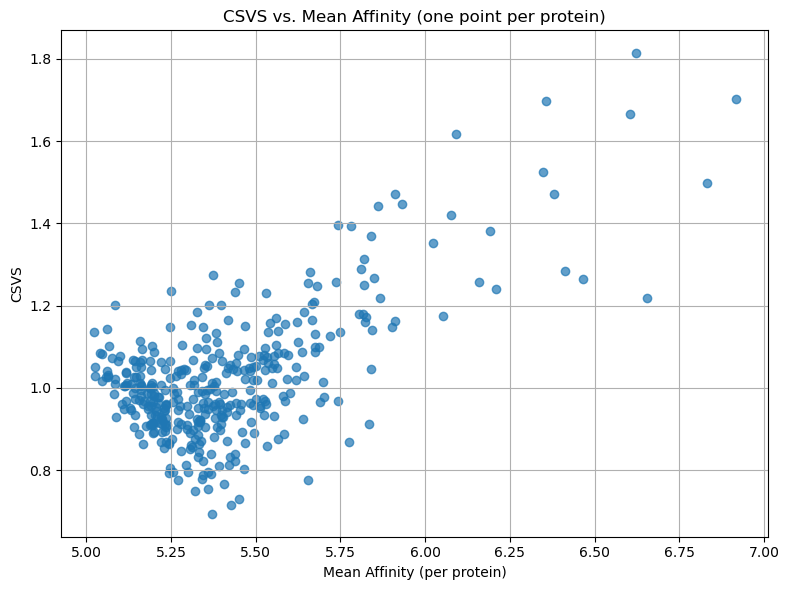

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Get the mean true affinity per protein from merged_df
mean_affinity_per_protein = merged_df.groupby("Protein_ID")["True_Label"].mean()

# Step 2: Ensure CSVS values are in a DataFrame for merging
csvs_df = pd.DataFrame({"Protein_ID": csvs.index, "CSVS": csvs.values})
csvs_df = csvs_df.set_index("Protein_ID")

# Step 3: Join with mean affinity
csvs_with_affinity = csvs_df.join(mean_affinity_per_protein)

# Step 4: Sort by True Affinity
csvs_sorted_by_affinity = csvs_with_affinity.sort_values("True_Label")

# Step 5: Plot
csvs_sorted_by_affinity["CSVS"].plot(kind='bar', figsize=(12, 5), title="Cold Start Vulnerability Sorted by Mean True Affinity")
plt.ylabel("CSVS")
plt.xlabel("Protein ID (sorted by mean affinity)")
plt.tight_layout()
plt.show()


# Step 1: Map per-protein CSVS to each row in merged_df
merged_df["CSVS"] = merged_df["Protein_ID"].map(csvs)

# Step 2: Plot CSVS vs. True Affinity
plt.figure(figsize=(8, 5))
plt.scatter(merged_df["True_Label"], merged_df["CSVS"], alpha=0.5)
plt.title("Cold Start Vulnerability vs. True Affinity")
plt.xlabel("True Affinity")
plt.ylabel("CSVS (per protein)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute mean affinity per protein
mean_affinity = merged_df.groupby("Protein_ID")["True_Label"].mean()
df_plot = pd.DataFrame({
    "CSVS": csvs_per_protein,
    "Mean_Affinity": mean_affinity
}).dropna()

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_plot["Mean_Affinity"], df_plot["CSVS"], alpha=0.7)
plt.xlabel("Mean Affinity (per protein)")
plt.ylabel("CSVS")
plt.title("CSVS vs. Mean Affinity (one point per protein)")
plt.grid(True)
plt.tight_layout()
plt.show()


Ok so then stratify this by affinity and see if there is a trend? And then plot. And then see if you can predict how far off pharos predictions will be for each affinity based on the DAVIS blinded

Trying to stratify by affinity rather than protein since each protein has interactions with wildly different affinities and really it seems that affinity causes the trend of over/under prediction.

In [48]:
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from scipy.spatial import ConvexHull

def compute_CHR_per_affinity_level(merged_df, min_affinity=5):
    """
    Computes CHR per floored integer affinity level ≥ min_affinity.
    """
    merged_df["Affinity_Level"] = merged_df["True_Label"].astype(int)
    CHR_dict = {}

    for level, group in merged_df.groupby("Affinity_Level"):
        if level < min_affinity:
            continue

        points_unblinded = group[["True_Label", "Unblinded_Prediction"]].values
        points_blinded = group[["True_Label", "Blinded_Prediction"]].values

        if len(points_unblinded) < 3:
            continue  # Convex hull requires ≥3 points

        try:
            hull = ConvexHull(points_unblinded)
            polygon = Polygon(points_unblinded[hull.vertices])

            inside_mask = np.array([polygon.contains(Point(p)) for p in points_blinded])
            CHR = (~inside_mask).sum() / len(points_blinded)
            CHR_dict[level] = CHR
        except:
            continue  # Skip degenerate or collinear cases

    return pd.Series(CHR_dict)


def compute_CSPD_per_affinity_level(merged_df, min_affinity=5):
    """
    Computes CSPD per floored integer affinity level ≥ min_affinity.
    """
    merged_df["NPD"] = (
        merged_df["Unblinded_Prediction"] - merged_df["Blinded_Prediction"]
    ) / merged_df["True_Label"]

    merged_df["Affinity_Level"] = merged_df["True_Label"].astype(int)
    CSPD = merged_df.groupby("Affinity_Level")["NPD"].mean()
    return CSPD[CSPD.index >= min_affinity].abs().rename("CSPD")


def compute_CSVS_affinity_level(merged_df, min_affinity=5, alpha=None, beta=None):
    """
    Combines CSPD and CHR per integer affinity level ≥ min_affinity.
    Returns model-level CSVS and per-affinity-level scores.
    """
    CSPD = compute_CSPD_per_affinity_level(merged_df, min_affinity)
    CHR = compute_CHR_per_affinity_level(merged_df, min_affinity)

    # Align levels
    common_levels = CSPD.index.intersection(CHR.index)
    CSPD = CSPD.loc[common_levels]
    CHR = CHR.loc[common_levels]

    # Normalize weights
    if alpha is None:
        alpha = 1 / CSPD.max()
    if beta is None:
        beta = 1 / CHR.max()

    csvs_per_level = alpha * CSPD + beta * CHR
    csvs_model = csvs_per_level.mean()

    return csvs_model, csvs_per_level, alpha, beta


#add conf intervals to chart

Model-level CSVS: 1.0660
5     0.946655
6     0.482040
7     0.638456
8     0.983177
9     1.345584
10    2.000000
dtype: float64


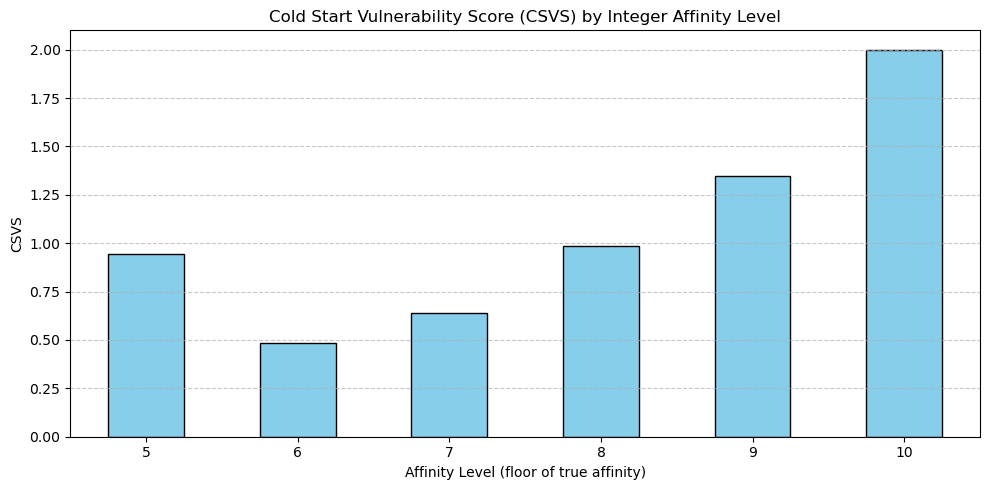

In [49]:
import matplotlib.pyplot as plt
csvs_model, csvs_per_level, alpha_used, beta_used = compute_CSVS_affinity_level(merged_df)



print(f"Model-level CSVS: {csvs_model:.4f}")
print(csvs_per_level)

# Plot CSVS per integer affinity level
csvs_per_level.sort_index().plot(
    kind='bar',
    figsize=(10, 5),
    title="Cold Start Vulnerability Score (CSVS) by Integer Affinity Level",
    color='skyblue',
    edgecolor='black'
)

plt.ylabel("CSVS")
plt.xlabel("Affinity Level (floor of true affinity)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [50]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Training data
X = np.array([5, 6, 7, 8, 9, 10]).reshape(-1, 1)
y = np.array([1.065899, 0.550373, 0.792733, 1.051455, 1.402107, 2.000000])

# Fit a polynomial model
model = make_pipeline(PolynomialFeatures(degree=1), LinearRegression())
model.fit(X, y)

model2 = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model2.fit(X, y)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

SO fit a linear regression (degree 1 and degree 2) model to the affinity stratified csvs and then use this to predict csvs for pharos. And then compare the csvs for each pharos point to the  actual prediction error

Best fit polynomial of degree 1:
 
-3.675 x + 4.494
R² of the fit: 0.1712


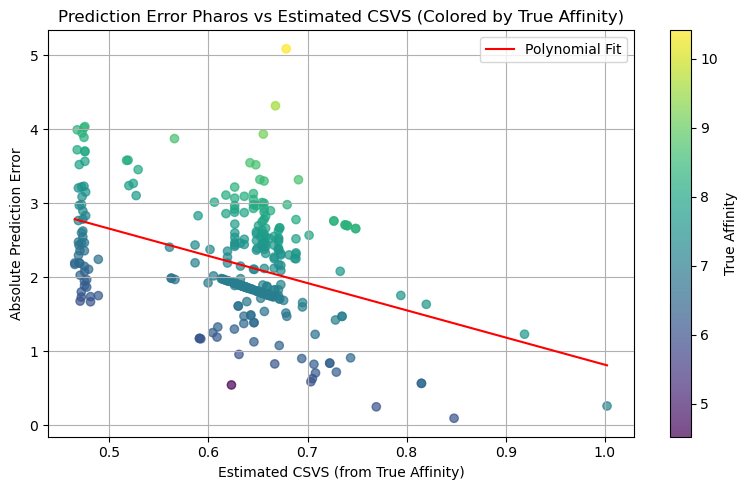

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

pharos_file = "new/pharos_test_predictions_GINConvNet.csv"
pharos_df = pd.read_csv(pharos_file)

# Predict estimated CSVS
#pharos_df["Estimated_CSVS"] = model.predict(pharos_df["True_Label"].values.reshape(-1, 1))
pharos_df["Estimated_CSVS"] = model.predict(pharos_df["Predicted_Value"].values.reshape(-1, 1))

# Compute absolute prediction error
pharos_df["Abs_Error"] = np.abs(pharos_df["True_Label"] - pharos_df["Predicted_Value"])

# Fit polynomial
degree = 1  
x = pharos_df["Estimated_CSVS"]
y = pharos_df["Abs_Error"]
c = pharos_df["True_Label"]
coeffs = np.polyfit(x, y, degree)
poly_eq = np.poly1d(coeffs)

# Predict y-values from the model
y_pred = poly_eq(x)

# Compute and print R²
r_squared = r2_score(y, y_pred)
print(f"Best fit polynomial of degree {degree}:")
print(poly_eq)
print(f"R² of the fit: {r_squared:.4f}")

# Plotting
plt.figure(figsize=(8, 5))
sc = plt.scatter(x, y, c=c, cmap='viridis', alpha=0.7)
cbar = plt.colorbar(sc)
cbar.set_label('True Affinity')

x_vals = np.linspace(x.min(), x.max(), 200)
y_vals = poly_eq(x_vals)
plt.plot(x_vals, y_vals, color='red', label='Polynomial Fit')

plt.xlabel("Estimated CSVS (from True Affinity)")
plt.ylabel("Absolute Prediction Error")
plt.title("Prediction Error Pharos vs Estimated CSVS (Colored by True Affinity)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Best fit polynomial of degree 2:
        2
-6.461 x + 15.57 x - 6.692
R² of the fit: 0.1642


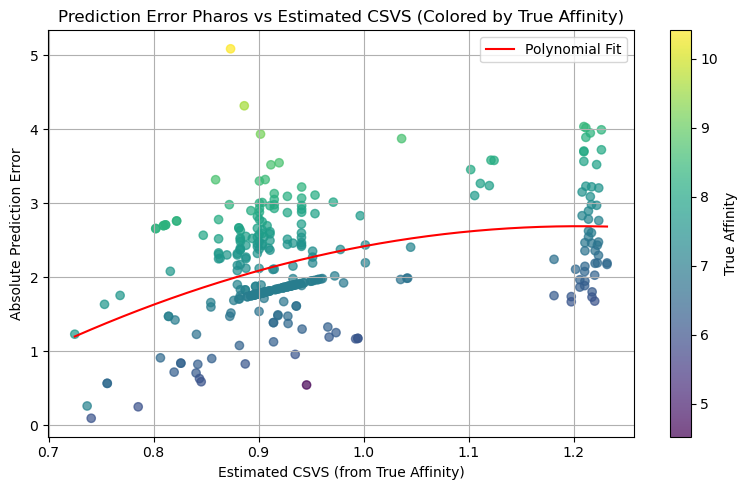

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

pharos_file = "new/pharos_test_predictions_GINConvNet.csv"
pharos_df = pd.read_csv(pharos_file)

# Predict estimated CSVS
#pharos_df["Estimated_CSVS"] = model2.predict(pharos_df["True_Label"].values.reshape(-1, 1))
pharos_df["Estimated_CSVS"] = model2.predict(pharos_df["Predicted_Value"].values.reshape(-1, 1))

# Compute absolute prediction error
pharos_df["Abs_Error"] = np.abs(pharos_df["True_Label"] - pharos_df["Predicted_Value"])

# Fit polynomial
degree = 2  
x = pharos_df["Estimated_CSVS"]
y = pharos_df["Abs_Error"]
c = pharos_df["True_Label"]
coeffs = np.polyfit(x, y, degree)
poly_eq = np.poly1d(coeffs)

# Predict y-values from the model
y_pred = poly_eq(x)

# Compute and print R²
r_squared = r2_score(y, y_pred)
print(f"Best fit polynomial of degree {degree}:")
print(poly_eq)
print(f"R² of the fit: {r_squared:.4f}")

# Plotting
plt.figure(figsize=(8, 5))
sc = plt.scatter(x, y, c=c, cmap='viridis', alpha=0.7)
cbar = plt.colorbar(sc)
cbar.set_label('True Affinity')

x_vals = np.linspace(x.min(), x.max(), 200)
y_vals = poly_eq(x_vals)
plt.plot(x_vals, y_vals, color='red', label='Polynomial Fit')

plt.xlabel("Estimated CSVS (from True Affinity)")
plt.ylabel("Absolute Prediction Error")
plt.title("Prediction Error Pharos vs Estimated CSVS (Colored by True Affinity)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


log log? no

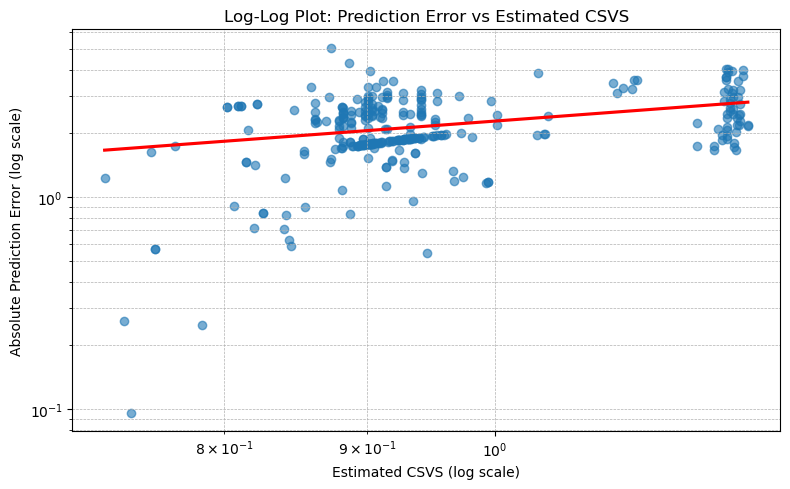

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.regplot(
    x="Estimated_CSVS", 
    y="Abs_Error", 
    data=pharos_df, 
    scatter_kws={'alpha': 0.6}, 
    line_kws={'color': 'red'}, 
    ci=None
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Estimated CSVS (log scale)")
plt.ylabel("Absolute Prediction Error (log scale)")
plt.title("Log-Log Plot: Prediction Error vs Estimated CSVS")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()


plot relation btwn convex hull and pred diff (CHR and CSPD) at all levels

- look into if CHR is a defined thing: PARAMETER FREE outlier identification

model level - decide how to compute cspd to not lose affinity info 
- dont know still but maybe better to have this act as just a general metric and have the affinity level and protein level metric be used to contetualize further

affinity level

protein level

see if the difference in metrics at each "level" can reveal anything about the model itself/ when to use it for cold start / how to fix the model for cold start cases

think about how to simplify the calculation of the metric in terms of work needed to get the data to compute it? 
- need blinded vs unblinded predictions
- could do only one repeat and have a way smaller sample size but probabliy similar results

# Model Level

In [54]:
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from scipy.spatial import ConvexHull

def compute_CHR_model_level_global(merged_df, min_points=3):
    """
    Computes model-level CHR as a single value:
    Fraction of all blinded points that fall outside
    the convex hull of all unblinded points.
    """
    points_unblinded = merged_df[["True_Label", "Unblinded_Prediction"]].values
    points_blinded = merged_df[["True_Label", "Blinded_Prediction"]].values

    if len(points_unblinded) < min_points:
        raise ValueError("Not enough unblinded points to construct convex hull.")

    try:
        hull = ConvexHull(points_unblinded)
        polygon = Polygon(points_unblinded[hull.vertices])

        inside_mask = np.array([polygon.contains(Point(p)) for p in points_blinded])
        chr_value = (~inside_mask).sum() / len(points_blinded)
        return chr_value

    except Exception as e:
        print(f"Convex hull computation failed: {e}")
        return np.nan



def compute_CSPD_model_level_global(merged_df, min_affinity=5):
    """
    Computes model-level CSPD as the mean absolute normalized prediction deviation (NPD)
    across all points with True_Label ≥ min_affinity.
    """
    df = merged_df.copy()
    df = df[df["True_Label"] >= min_affinity]

    # Avoid division by zero
    df = df[df["True_Label"] != 0]

    if df.empty:
        raise ValueError("No valid data points after applying min_affinity filter.")

    df["NPD"] = (df["Unblinded_Prediction"] - df["Blinded_Prediction"]) / df["True_Label"]
    cspd_value = df["NPD"].abs().mean()
    return cspd_value



def compute_CSVS_model_level_global(merged_df, min_affinity=5, alpha=None, beta=None):
    """
    Computes model-level CSVS using global (non-grouped) CSPD and CHR.
    Returns:
        - scalar CSVS value
        - CSPD scalar
        - CHR scalar
        - alpha, beta used
    """
    # Get global CSPD and CHR
    CSPD = compute_CSPD_model_level_global(merged_df, min_affinity)
    CHR = compute_CHR_model_level_global(merged_df, min_affinity)

    # Normalize weights
    if alpha is None:
        alpha = 1 / CSPD if CSPD != 0 else 0
    if beta is None:
        beta = 1 / CHR if CHR != 0 else 0

    # Compute scalar CSVS
    csvs_model = alpha * CSPD + beta * CHR

    return csvs_model, CSPD, CHR, alpha, beta



In [55]:
csvs_model, cspd, chr, alpha_used, beta_used = compute_CSVS_model_level_global(merged_df, alpha=1, beta=1)
print(f"Model-level CSVS: {csvs_model:.4f}")
print(f"  CSPD: {cspd:.4f}, {cspd*alpha_used}, CHR: {chr:.4f}, {chr*beta_used}")
print(f"  alpha: {alpha_used:.4f}, beta: {beta_used:.4f}")


Model-level CSVS: 0.7617
  CSPD: 0.0614, 0.06140086572246206, CHR: 0.7003, 0.7003004959994207
  alpha: 1.0000, beta: 1.0000


In [79]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from scipy.spatial import ConvexHull, Delaunay

def compute_directional_CHR_from_arrays(unblinded, blinded, min_points=3):
    """
    Computes directional CHR using raw NumPy arrays of unblinded and blinded points.
    Format: each array is shape (N, 2) with [True_Label, Prediction].

    Returns:
    - chr_value: scalar CHR (fraction of points outside)
    - directions: list of unit direction vectors from hull boundary to outside points
    - magnitudes: list of distances from each outside point to the convex hull
    - inside_mask: boolean array indicating which blinded points are inside
    """
    if len(unblinded) < min_points:
        raise ValueError("Not enough unblinded points to construct convex hull.")

    try:
        hull = ConvexHull(unblinded)
        hull_points = unblinded[hull.vertices]
        boundary = LineString(hull_points.tolist() + [hull_points[0].tolist()])  # close the loop

        delaunay = Delaunay(hull_points)
        inside_mask = delaunay.find_simplex(blinded) >= 0
        outside_points = blinded[~inside_mask]

        directions = []
        magnitudes = []

        for p in outside_points:
            point = Point(p)
            nearest = boundary.interpolate(boundary.project(point))
            vec = np.array(p) - np.array([nearest.x, nearest.y])
            mag = np.linalg.norm(vec)
            if mag > 1e-8:
                directions.append(vec / mag)
                magnitudes.append(mag)
            else:
                directions.append(np.array([0.0, 0.0]))
                magnitudes.append(0.0)

        chr_value = len(outside_points) / len(blinded)
        return chr_value, directions, magnitudes, inside_mask

    except Exception as e:
        print(f"Convex hull computation failed: {e}")
        return np.nan, [], [], np.array([False] * len(blinded))


import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import matplotlib.patches as mpatches

def plot_directional_CHR_from_arrays(unblinded, blinded, directions, magnitudes, inside_mask,
                                     chr_value, scale=0.2, title="Directional CHR Plot"):
    """
    Plots convex hull, unblinded and blinded points, and arrows from outside points toward the hull.

    Parameters:
    - unblinded: Nx2 array of [True_Label, Prediction]
    - blinded: Mx2 array of [True_Label, Prediction]
    - directions: unit vectors from outside points (same length as magnitudes)
    - magnitudes: distances from outside points to the convex hull
    - inside_mask: boolean mask (True for inside, False for outside)
    - chr_value: scalar CHR
    - scale: arrow length scaling
    - title: plot title
    """
    outside_points = blinded[~inside_mask]

    hull = ConvexHull(unblinded)
    plt.figure(figsize=(8, 6))

    # Plot points
    plt.scatter(unblinded[:, 0], unblinded[:, 1], c='blue', alpha=0.5, label="Unblinded")
    plt.scatter(blinded[:, 0], blinded[:, 1], c='green', alpha=0.5, label="Blinded")
    plt.scatter(outside_points[:, 0], outside_points[:, 1], c='red', marker='x', label="Outside Points")

    # Plot convex hull
    for simplex in hull.simplices:
        plt.plot(unblinded[simplex, 0], unblinded[simplex, 1], 'k--')

    # Plot directional deviation arrows
    for p, d, m in zip(outside_points, directions, magnitudes):
        end = p + d * (scale * m)
        plt.arrow(p[0], p[1], end[0] - p[0], end[1] - p[1],
                  head_width=0.05, head_length=0.1, fc='yellow', ec='yellow', alpha=0.7)

    # Custom legend entry for direction arrows
    yellow_patch = mpatches.Patch(color='yellow', label='Direction of Deviation')

    plt.legend(handles=[
        plt.Line2D([], [], marker='o', color='w', label='Simulated Warm Start', markerfacecolor='blue', alpha=0.5),
        plt.Line2D([], [], marker='o', color='w', label='True Cold Start (Pharos)', markerfacecolor='green', alpha=0.5),
        plt.Line2D([], [], marker='x', color='red', linestyle='None', label='Outside Convex Hull'),
        yellow_patch
    ])


    plt.title(f"{title} (CHR = {chr_value:.4f})")
    plt.xlabel("True Affinity")
    plt.ylabel("Predicted Affinity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()




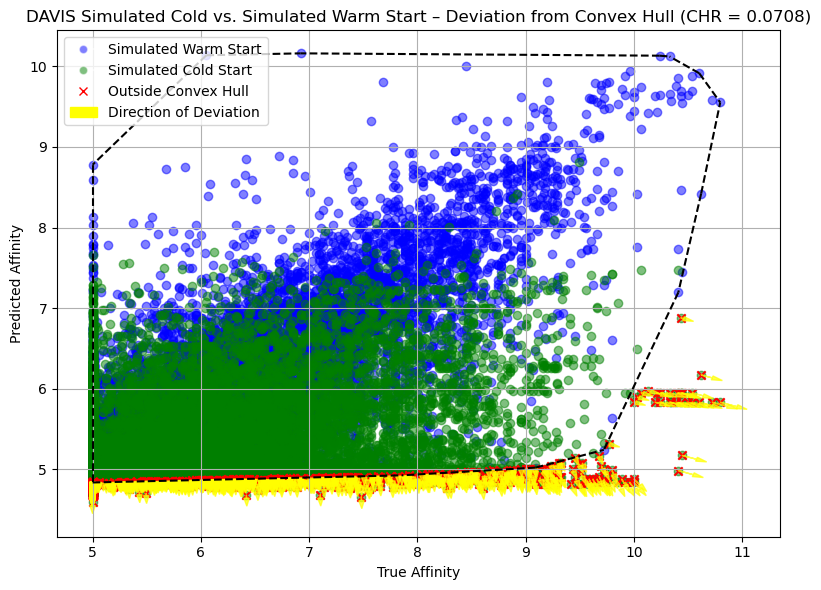

27621
27621
CHR: 0.0708
Number of outliers: 1956
Average deviation distance: 0.0469
Average direction vector: [ 0.03875438 -0.988342  ]
Unit direction: [ 0.03918139 -0.99923211]
Magnitude of average direction (coherence): 0.9891015150002865


In [77]:
# Compute and plot CHR for DAVIS blinded
chr_blinded, directions_b, magnitudes_b, mask_b = compute_directional_CHR_from_arrays(unblinded, blinded)
plot_directional_CHR_from_arrays(unblinded, blinded, directions_b, magnitudes_b, mask_b, chr_blinded,
                                 title="DAVIS Simulated Cold vs. Simulated Warm Start – Deviation from Convex Hull")

print(len(unblinded))
print(len(blinded))
print(f"CHR: {chr_blinded:.4f}")
print(f"Number of outliers: {len(magnitudes_b)}")
print(f"Average deviation distance: {np.mean(magnitudes_b):.4f}")
# Stack directions into a 2D array
direction_array = np.vstack(directions_b)  # shape (N, 2)

# Vector sum and mean direction
mean_vector = direction_array.mean(axis=0)
mean_magnitude = np.linalg.norm(mean_vector)

# Unit vector of average direction
mean_unit_direction = mean_vector / mean_magnitude if mean_magnitude != 0 else np.array([0.0, 0.0])

print("Average direction vector:", mean_vector)
print("Unit direction:", mean_unit_direction)
print("Magnitude of average direction (coherence):", mean_magnitude)

Make scatter plot of direction vectors and magnitudes

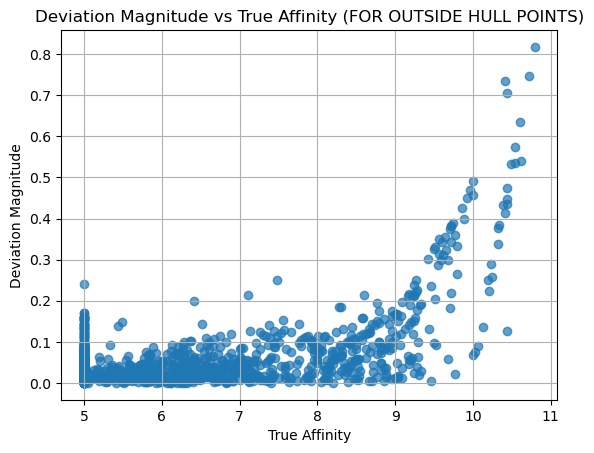

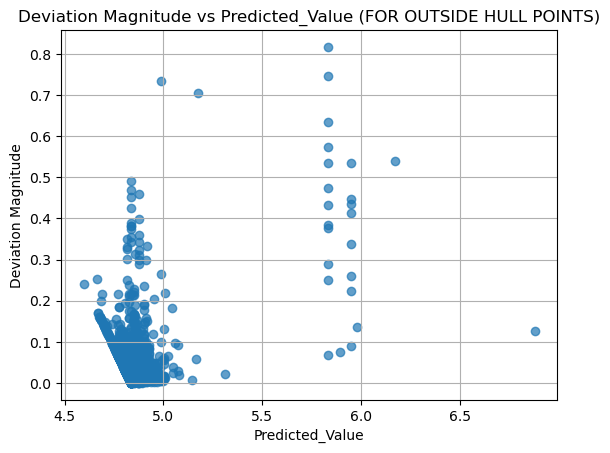

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
blinded_df = pd.read_csv("new/concatenated_final_test_predictions.csv")

# Extract the true affinities from the DataFrame
true_affinities_blinded = blinded_df["True_Label"].values

# Plot deviation magnitudes vs true affinities
plt.figure()
plt.scatter(true_affinities_blinded[~mask_b], magnitudes_b, alpha=0.7)
plt.xlabel("True Affinity")
plt.ylabel("Deviation Magnitude")
plt.title("Deviation Magnitude vs True Affinity (FOR OUTSIDE HULL POINTS)")
plt.grid(True)
plt.show()

# Extract the true affinities from the DataFrame
pred_affinities_blinded = blinded_df["Predicted_Value"].values

# Plot deviation magnitudes vs true affinities
plt.figure()
plt.scatter(pred_affinities_blinded[~mask_b], magnitudes_b, alpha=0.7)
plt.xlabel("Predicted_Value")
plt.ylabel("Deviation Magnitude")
plt.title("Deviation Magnitude vs Predicted_Value (FOR OUTSIDE HULL POINTS)")
plt.grid(True)
plt.show()


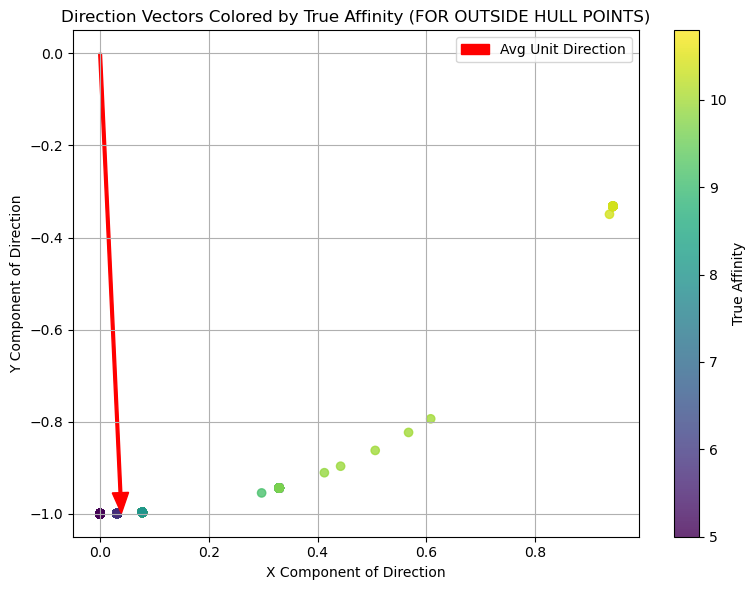

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Stack direction vectors
direction_array = np.vstack(directions_b)  # shape (N, 2)
x_dirs = direction_array[:, 0]
y_dirs = direction_array[:, 1]

# True affinities for outliers
true_affs_outliers = true_affinities_blinded[~mask_b]
unique_dirs = np.unique(direction_array, axis=0)

# Compute average unit direction vector
norms = np.linalg.norm(direction_array, axis=1, keepdims=True)
unit_dirs = direction_array / norms
avg_unit_dir = unit_dirs.mean(axis=0)
avg_unit_dir /= np.linalg.norm(avg_unit_dir)  # normalize again just in case

# Set a scaling factor to make the arrow visible (optional: scale to data spread)
arrow_scale = 1.0  # change this if you want a longer or shorter arrow
arrow_vector = avg_unit_dir * arrow_scale

# Create scatter plot with color indicating true affinity
plt.figure(figsize=(8, 6))
sc = plt.scatter(x_dirs, y_dirs, c=true_affs_outliers, cmap='viridis', alpha=0.8)
plt.xlabel("X Component of Direction")
plt.ylabel("Y Component of Direction")
plt.title("Direction Vectors Colored by True Affinity (FOR OUTSIDE HULL POINTS)")
plt.colorbar(sc, label="True Affinity")
plt.grid(True)
# Overlay average unit direction vector from origin
plt.arrow(0, 0, arrow_vector[0], arrow_vector[1], 
          color='red', width=0.005, head_width=0.03, length_includes_head=True, label='Avg Unit Direction')

plt.legend()
plt.tight_layout()
plt.show()


Do x as x and y as y and use color gradient to show affinity
and line as unit direction

Report unit directions for blinded vs pharos and skip the magnitude plots

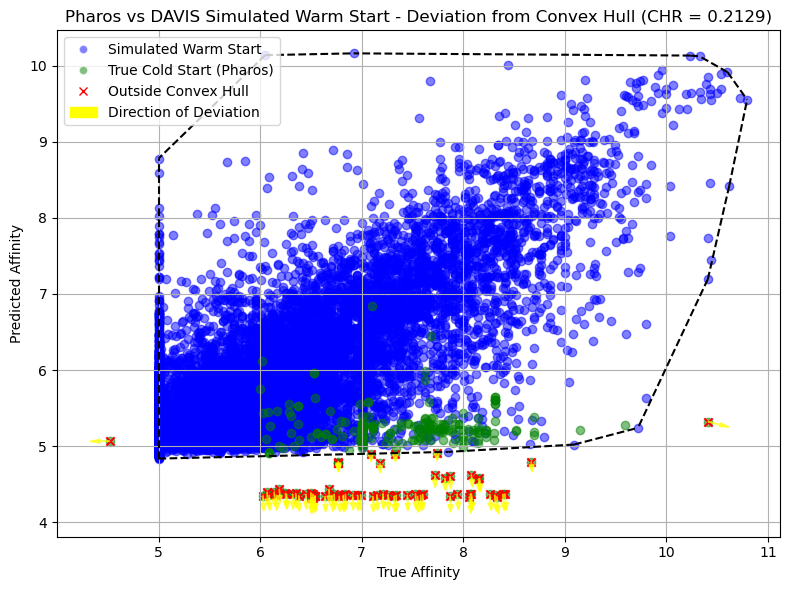

CHR: 0.2129
Number of outliers: 66
Average deviation distance: 0.4653
Average direction vector: [ 0.03860013 -0.97375568]
Unit direction: [ 0.03960936 -0.99921524]
Magnitude of average direction (coherence): 0.9745204396648737


In [80]:
chr_val_p, directions_p, magnitudes_p, mask_p = compute_directional_CHR_from_arrays(unblinded, pharos)
plot_directional_CHR_from_arrays(unblinded, pharos, directions_p, magnitudes_p, mask_p, chr_val_p, title="Pharos vs DAVIS Simulated Warm Start - Deviation from Convex Hull")

print(f"CHR: {chr_val_p:.4f}")
print(f"Number of outliers: {len(magnitudes_p)}")
print(f"Average deviation distance: {np.mean(magnitudes_p):.4f}")
# Stack directions into a 2D array
direction_array = np.vstack(directions_p)  # shape (N, 2)

# Vector sum and mean direction
mean_vector = direction_array.mean(axis=0)
mean_magnitude = np.linalg.norm(mean_vector)
#Add math definition

# Unit vector of average direction
mean_unit_direction = mean_vector / mean_magnitude if mean_magnitude != 0 else np.array([0.0, 0.0])

print("Average direction vector:", mean_vector)
print("Unit direction:", mean_unit_direction)
print("Magnitude of average direction (coherence):", mean_magnitude)


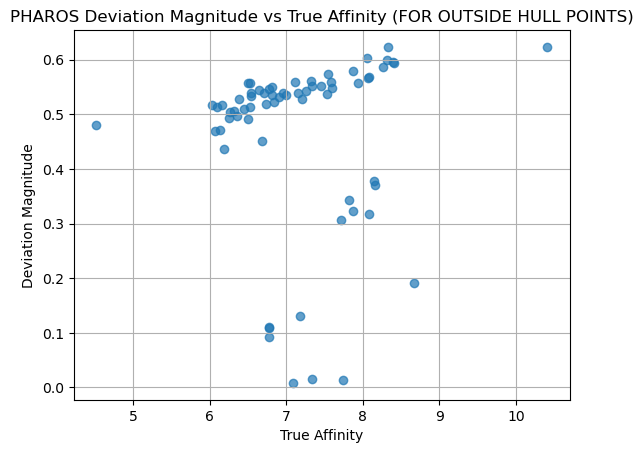

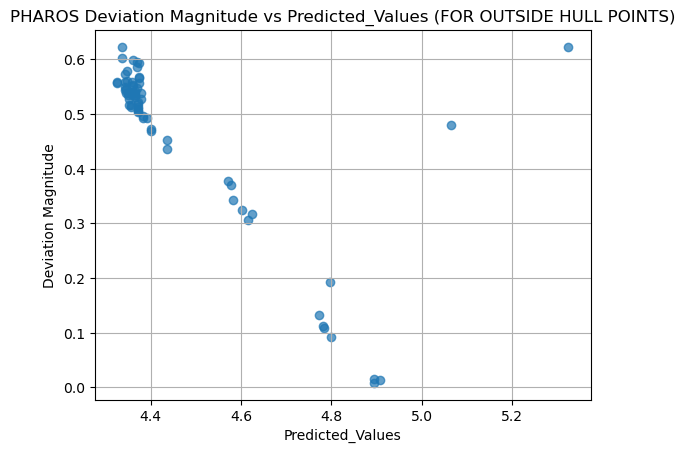

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the true affinities from the DataFrame
true_affinities_pharos = pharos_df["True_Label"].values

# Plot deviation magnitudes vs true affinities
plt.figure()
plt.scatter(true_affinities_pharos[~mask_p], magnitudes_p, alpha=0.7)
plt.xlabel("True Affinity")
plt.ylabel("Deviation Magnitude")
plt.title("PHAROS Deviation Magnitude vs True Affinity (FOR OUTSIDE HULL POINTS)")
plt.grid(True)
plt.show()

# Extract the true affinities from the DataFrame
preds_pharos = pharos_df["Predicted_Value"].values

# Plot deviation magnitudes vs true affinities
plt.figure()
plt.scatter(preds_pharos[~mask_p], magnitudes_p, alpha=0.7)
plt.xlabel("Predicted_Values")
plt.ylabel("Deviation Magnitude")
plt.title("PHAROS Deviation Magnitude vs Predicted_Values (FOR OUTSIDE HULL POINTS)")
plt.grid(True)
plt.show()


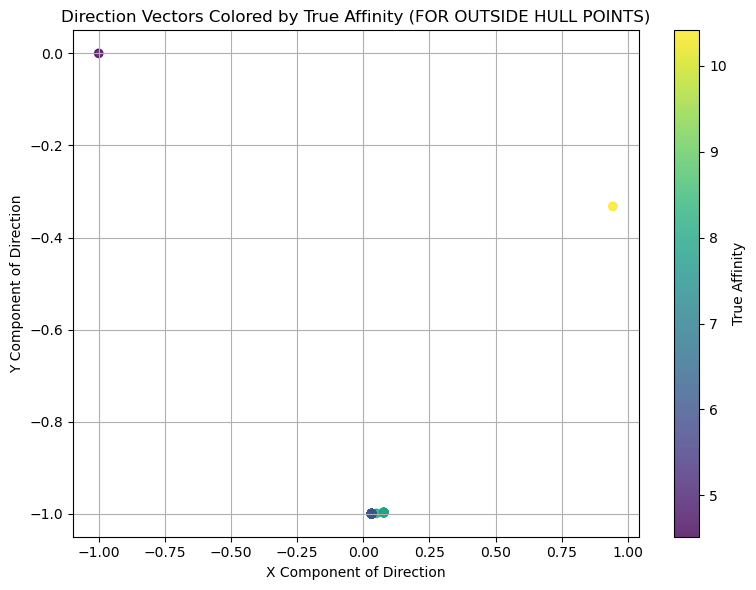

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Stack direction vectors
direction_array = np.vstack(directions_p)  # shape (N, 2)
x_dirs = direction_array[:, 0]
y_dirs = direction_array[:, 1]

# True affinities for outliers
true_affs_outliers = true_affinities_pharos[~mask_p]

# Create scatter plot with color indicating true affinity
plt.figure(figsize=(8, 6))
sc = plt.scatter(x_dirs, y_dirs, c=true_affs_outliers, cmap='viridis', alpha=0.8)
plt.xlabel("X Component of Direction")
plt.ylabel("Y Component of Direction")
plt.title("Direction Vectors Colored by True Affinity (FOR OUTSIDE HULL POINTS)")
plt.colorbar(sc, label="True Affinity")
plt.grid(True)
plt.tight_layout()
plt.show()



Add some type of number to the unblinded inside the convex hull

Add examples of extremes - make them up

how to use the info...  Try modifying the stopping condition/ training loop to include information on direction & try to get it close to inside the hull. or if the point is outside the true label range leave it. 

If a predicted point is outside the hull: Compute the direction back toward the hull boundary. Add a small penalty term that encourages moving back inward

More agressive if coherence higher

as for cspd ... if i make a smaller subset (maybe select by affinity) and have a blinded-unblinded set up for it within the training loop then I could try to minimize cspd? 

FOR INSIDE HULL POINTS: using distance from the hull boundry: maximal would indicate point is more inside the data cloud... but depends on the data's distribution (think of a ring of data with unblinded in the middle then this would be not good)

using distance from lobf of unblinded: would show how closely the points conform to the linear trend in the unblinded data. Smaller distances indicate better adherence to the same linear trend

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, LineString
from scipy.spatial import ConvexHull, Delaunay
from sklearn.linear_model import LinearRegression

def compute_distances_inside_hull(unblinded, blinded, min_points=3):
    if len(unblinded) < min_points:
        raise ValueError("Not enough unblinded points to construct convex hull.")

    try:
        hull = ConvexHull(unblinded)
        hull_points = unblinded[hull.vertices]
        hull_boundary = LineString(hull_points.tolist() + [hull_points[0].tolist()])

        delaunay = Delaunay(hull_points)
        inside_mask = delaunay.find_simplex(blinded) >= 0
        inside_points = blinded[inside_mask]

        reg = LinearRegression()
        reg.fit(unblinded[:, 0].reshape(-1, 1), unblinded[:, 1])
        lobf_line = LineString([
            (unblinded[:, 0].min(), reg.predict([[unblinded[:, 0].min()]])[0]),
            (unblinded[:, 0].max(), reg.predict([[unblinded[:, 0].max()]])[0])
        ])

        inside_distances_hull = []
        inside_vectors_hull = []

        inside_distances_lobf = []
        inside_vectors_lobf = []

        for p in inside_points:
            point = Point(p)

            # Hull
            nearest_hull = hull_boundary.interpolate(hull_boundary.project(point))
            vec_hull = np.array([nearest_hull.x - point.x, nearest_hull.y - point.y])
            inside_distances_hull.append(np.linalg.norm(vec_hull))
            inside_vectors_hull.append(vec_hull)

            # LOBF
            nearest_lobf = lobf_line.interpolate(lobf_line.project(point))
            vec_lobf = np.array([nearest_lobf.x - point.x, nearest_lobf.y - point.y])
            inside_distances_lobf.append(np.linalg.norm(vec_lobf))
            inside_vectors_lobf.append(vec_lobf)

        # Convert vectors to arrays
        inside_vectors_hull = np.array(inside_vectors_hull)
        inside_vectors_lobf = np.array(inside_vectors_lobf)

        # Compute and print averages
        avg_dev_hull = np.mean(inside_distances_hull)
        avg_vec_hull = np.mean(inside_vectors_hull, axis=0)
        coherence_hull = np.linalg.norm(avg_vec_hull)

        avg_dev_lobf = np.mean(inside_distances_lobf)
        avg_vec_lobf = np.mean(inside_vectors_lobf, axis=0)
        coherence_lobf = np.linalg.norm(avg_vec_lobf)

        print("Hull Distance Metrics:")
        print(f"  Average deviation distance: {avg_dev_hull:.4f}")
        print(f"  Average direction vector: {avg_vec_hull}")
        print(f"  Magnitude of average direction (coherence): {coherence_hull:.4f}")
        print("LOBF Distance Metrics:")
        print(f"  Average deviation distance: {avg_dev_lobf:.4f}")
        print(f"  Average direction vector: {avg_vec_lobf}")
        print(f"  Magnitude of average direction (coherence): {coherence_lobf:.4f}")

        return inside_distances_hull, inside_distances_lobf, inside_points, hull_boundary, lobf_line

    except Exception as e:
        print(f"Computation failed: {e}")
        return [], [], [], None, None

def plot_distances_inside_hull(unblinded, inside_points, inside_distances_hull, inside_distances_lobf, hull_boundary, lobf_line, title="Distances Inside Hull"):
    plt.figure(figsize=(8, 6))

    plt.scatter(unblinded[:, 0], unblinded[:, 1], c='blue', alpha=0.5, label="Unblinded")
    plt.scatter(inside_points[:, 0], inside_points[:, 1], c='green', alpha=0.5, label="Inside Points")

    for simplex in ConvexHull(unblinded).simplices:
        plt.plot(unblinded[simplex, 0], unblinded[simplex, 1], 'k--', label="Hull Boundary" if simplex[0] == 0 else "")

    plt.plot(*lobf_line.xy, 'r-', label="Line of Best Fit (LOBF)")

    # Removed per-point annotations to reduce clutter

    plt.title(title)
    plt.xlabel("True Affinity")
    plt.ylabel("Predicted Affinity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Simple inference model that takes in affinity and predict expected deviation and validate on pharos

compute confidence intervals if possible

helps show value

Hull Distance Metrics:
  Average deviation distance: 0.1739
  Average direction vector: [-0.02246032 -0.12889529]
  Magnitude of average direction (coherence): 0.1308
LOBF Distance Metrics:
  Average deviation distance: 0.3077
  Average direction vector: [-0.06620634  0.16830669]
  Magnitude of average direction (coherence): 0.1809


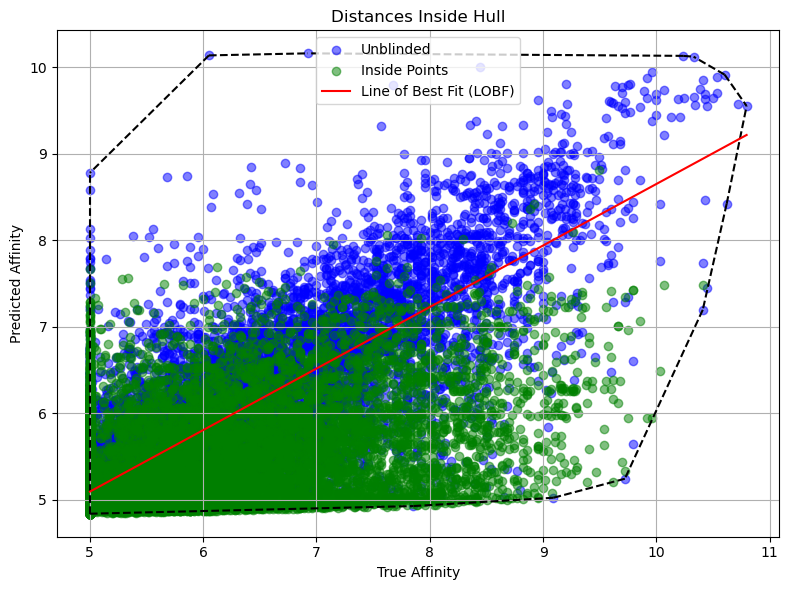

In [64]:
inside_distances_hull, inside_distances_lobf, inside_points, hull_boundary, lobf_line = compute_distances_inside_hull(unblinded, blinded)
plot_distances_inside_hull(unblinded, inside_points, inside_distances_hull, inside_distances_lobf, hull_boundary, lobf_line)


Vulnerability of an blinded point as the fraction of unblinded points which are nearer to the hull than it  or just fraction of blinded distance vs unblinded distance for each protein/drug pair: 

Top: # of unblinded proteins that are closer to the hull than my unblinded distance/ total # of unblinded proteins

Bottom: # of unblinded proteins that are closer to the hull than my blinded distance / total # of unblinded proteins


Have a reference set: all the unblinded predictions, and how close they are to the hull (how conforming they are).

Now asking:

“Where does my unblinded/blinded prediction sit in that distribution of conformity?”

This gives you a relative ranking:

If your prediction is near the hull, it’s similar to others → conforming

If it’s far from the hull, it’s unusual → non-conforming

In [65]:
from shapely.ops import nearest_points
from scipy.spatial import Delaunay

def compute_signed_distance_to_hull(polygon, delaunay, point):
    """Compute signed distance to hull: negative if inside, positive if outside"""
    pt = Point(point)
    nearest = nearest_points(pt, polygon.boundary)[1]
    dist = pt.distance(nearest)
    is_inside = delaunay.find_simplex([point])[0] >= 0
    return -dist if is_inside else dist

def compute_vulnerability_fractions_from_arrays(unblinded, blinded):
    """
    Compute conformity-based vulnerability using signed distances to the convex hull.
    Points inside the hull get negative distances; outside get positive.
    """
    # Construct convex hull polygon and Delaunay triangulation for inclusion checks
    hull = ConvexHull(unblinded)
    polygon = Polygon(unblinded[hull.vertices])
    delaunay = Delaunay(unblinded[hull.vertices])

    # Compute signed distances for each point
    dists_unblinded = np.array([
        compute_signed_distance_to_hull(polygon, delaunay, p) for p in unblinded
    ])
    dists_blinded = np.array([
        compute_signed_distance_to_hull(polygon, delaunay, p) for p in blinded
    ])

    # Add small epsilon to prevent equal-value ties
    epsilon = 1e-8
    top_fractions = np.array([
        np.sum(dists_unblinded < du - epsilon) / len(dists_unblinded)
        for du in dists_unblinded
    ])
    bottom_fractions = np.array([
        np.sum(dists_unblinded < db - epsilon) / len(dists_unblinded)
        for db in dists_blinded
    ])

    return top_fractions, bottom_fractions, dists_blinded, dists_unblinded


In [66]:
def plot_conformity_and_signed_distance(
    top_fractions, bottom_fractions, dists_unblinded, dists_blinded
):
    """
    Visualize point-level cold start vulnerability from a conformity perspective.
    Left: Conformity rank-based CSVS.
    Right: Geometry-based signed distance CSVS.
    """
    cs_scores = bottom_fractions - top_fractions

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # --- Plot 1: Rank-based conformity (fractional ranks) ---
    ax = axes[0]
    sc1 = ax.scatter(top_fractions, bottom_fractions, c=cs_scores, cmap="coolwarm", alpha=0.6)
    ax.plot([0, 1], [0, 1], 'r--', label="y = x (equal conformity)")
    ax.set_xlabel("Unblinded Conformity Rank (Lower = More In-Distribution)")
    ax.set_ylabel("Blinded Conformity Rank")
    ax.set_title("Per-Point CSVS (Conformity Rank Comparison)")
    ax.grid(True)
    ax.legend()
    plt.colorbar(sc1, ax=ax, label="CSVS = Blinded - Unblinded")

    # --- Plot 2: Signed distance to hull ---
    ax2 = axes[1]
    min_val = min(dists_unblinded.min(), dists_blinded.min())
    max_val = max(dists_unblinded.max(), dists_blinded.max())
    sc2 = ax2.scatter(dists_unblinded, dists_blinded, c=cs_scores, cmap="coolwarm", alpha=0.6)
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x (equal distance)")
    ax2.set_xlabel("Signed Distance to Hull (Unblinded)")
    ax2.set_ylabel("Signed Distance to Hull (Blinded)")
    ax2.set_title("Per-Point CSVS (Signed Distance Comparison)")
    ax2.grid(True)
    ax2.legend()
    plt.colorbar(sc2, ax=ax2, label="CSVS = Blinded - Unblinded")

    plt.suptitle("Conformity-Based Cold Start Vulnerability (Per-Point View)")
    plt.tight_layout()
    plt.show()


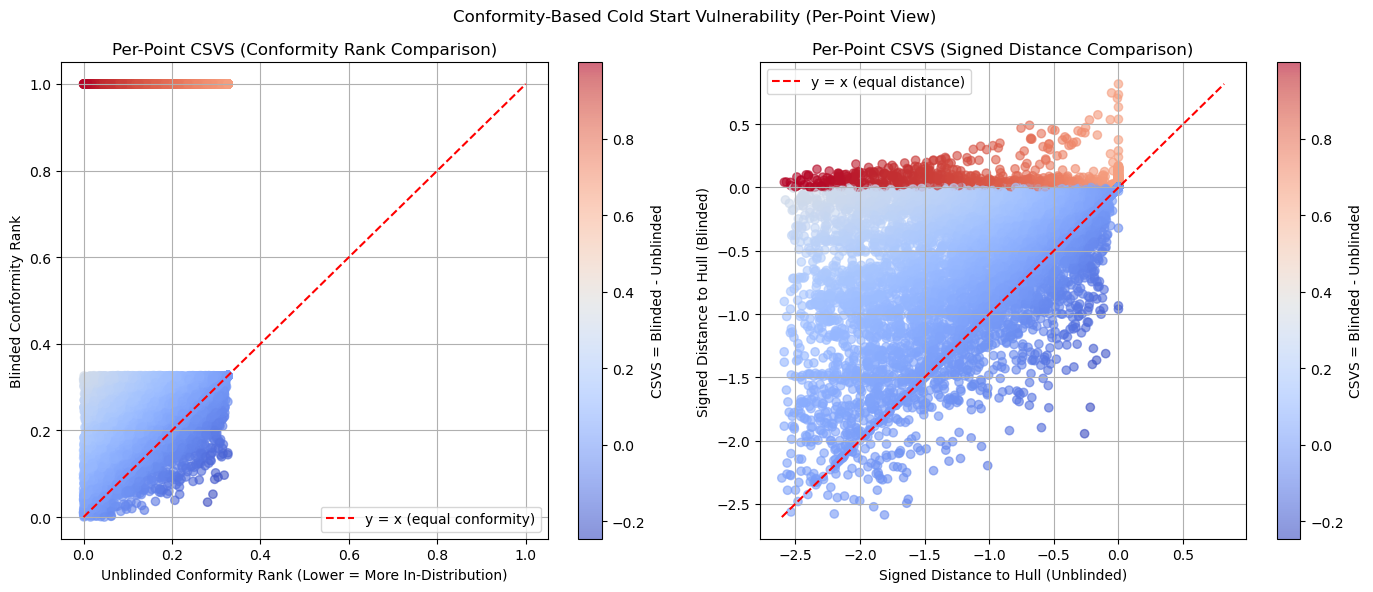

In [67]:
# File paths
unblinded_file = "new/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "new/concatenated_final_test_predictions.csv"

# Load and rename
df_unblinded = pd.read_csv(unblinded_file).rename(columns={"Predicted_Value": "Unblinded_Prediction"})
df_blinded = pd.read_csv(blinded_file).rename(columns={"Predicted_Value": "Blinded_Prediction"})

# Merge on IDs
merged_df = pd.merge(
    df_unblinded[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    df_blinded[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)

# Extract aligned (N, 2) arrays for the convex hull
unblinded = merged_df[["True_Label", "Unblinded_Prediction"]].values
blinded = merged_df[["True_Label", "Blinded_Prediction"]].values

# Now compute
top_fractions, bottom_fractions, dists_blinded, dists_unblinded = compute_vulnerability_fractions_from_arrays(unblinded, blinded)
plot_conformity_and_signed_distance(
    top_fractions, bottom_fractions, dists_unblinded, dists_blinded
)



Left plot: Shows which points become less conforming after blinding. Points above y = x are more vulnerable.

Right plot: Shows signed movement away from the unblinded distribution. Red = shifted further out; blue = shifted inward.

Color = per-point CSVS, measuring how much conformity dropped in the cold-start setting.


Define conformity as:

A point’s signed distance to the boundary of the convex hull formed by all unblinded predictions.

More specifically:

Inside the hull → assigned a negative distance (closer to core = more conforming)

Outside the hull → assigned a positive distance (further out = less conforming)

Then, you rank this distance among all unblinded distances to get a conformity rank:

Lower rank = more typical

Higher rank = less typical or more surprising



Positive CSVS:

Blinded prediction is less conforming than unblinded

→ model extrapolated in cold-start

→ vulnerability

Negative CSVS:

Blinded prediction is more conforming than unblinded

→ could mean over-regularization, or spurious “confidence”

Zero CSVS:

Model behaved consistently with what it did during training





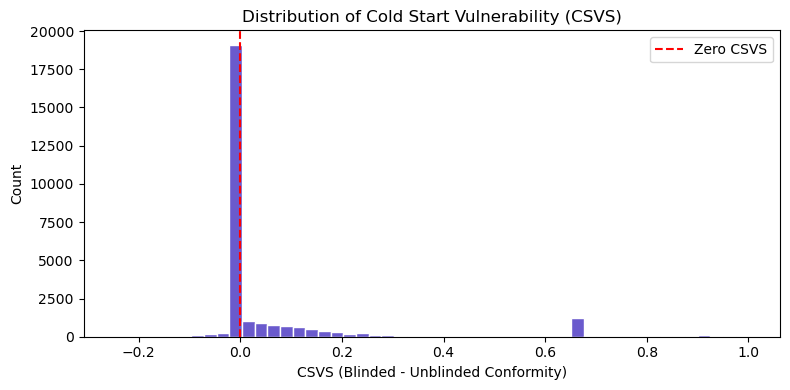

In [68]:
conformity_diff = bottom_fractions - top_fractions

plt.figure(figsize=(8, 4))
plt.hist(conformity_diff, bins=50, color='slateblue', edgecolor='white')
plt.axvline(0, color='red', linestyle='--', label='Zero CSVS')
plt.xlabel("CSVS (Blinded - Unblinded Conformity)")
plt.ylabel("Count")
plt.title("Distribution of Cold Start Vulnerability (CSVS)")
plt.legend()
plt.tight_layout()
plt.show()


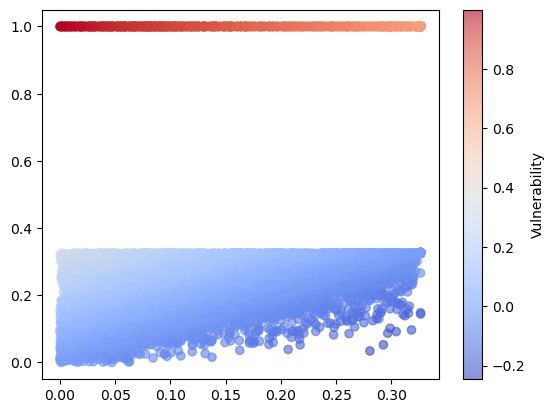

In [69]:
cs_scores = bottom_fractions - top_fractions
plt.scatter(top_fractions, bottom_fractions, c=cs_scores, cmap="coolwarm", alpha=0.6)
plt.colorbar(label="Vulnerability")


Using % hulls... are the inside points in denser areas of the distribution? or are they only marginally in-distribution?

In [70]:
import numpy as np
import pandas as pd
from shapely.geometry import Point, LineString
from scipy.spatial import ConvexHull, Delaunay
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors

def compute_chr(unblinded, blinded, coverage=0.75, use_lobf=True, k_neighbors=20):
    """
    Compute CHR and directionality metrics for points outside a high-density hull.
    
    Parameters:
        unblinded: np.ndarray of shape (N, 2)
        blinded: np.ndarray of shape (M, 2)
        coverage: float between 0 and 1, fraction of high-density points to include in hull
        use_lobf: if True, density is defined by deviation from LOBF; if False, deviation from y=x
        k_neighbors: for optional kNN-based local density cutoff (not used here yet)

    Returns:
        Dictionary of metrics: 
        - num_outliers
        - avg_deviation_distance
        - avg_direction_vector
        - coherence_magnitude
    """
    if len(unblinded) < 3:
        raise ValueError("Not enough unblinded points to construct convex hull.")
    
    # Step 1: Fit LOBF or use identity line y=x
    if use_lobf:
        reg = LinearRegression()
        reg.fit(unblinded[:, 0].reshape(-1, 1), unblinded[:, 1])
        residuals = np.abs(unblinded[:, 1] - reg.predict(unblinded[:, 0].reshape(-1, 1)))
    else:
        residuals = np.abs(unblinded[:, 1] - unblinded[:, 0])

    # Step 2: Select top-N most "on-trend" points
    threshold = np.quantile(residuals, coverage)
    high_density_mask = residuals <= threshold
    high_density_points = unblinded[high_density_mask]

    # Step 3: Build hull around these
    hull = ConvexHull(high_density_points)
    hull_points = high_density_points[hull.vertices]
    hull_polygon = hull_points
    hull_boundary = LineString(hull_points.tolist() + [hull_points[0].tolist()])
    delaunay = Delaunay(hull_points)
    inside_mask = delaunay.find_simplex(blinded) >= 0
    outside_points = blinded[~inside_mask]

    # Step 4: Measure vector distances to nearest hull boundary point
    distances = []
    vectors = []

    for pt in outside_points:
        point = Point(pt)
        nearest = hull_boundary.interpolate(hull_boundary.project(point))
        vec = np.array([nearest.x - point.x, nearest.y - point.y])
        vectors.append(vec)
        distances.append(np.linalg.norm(vec))

    vectors = np.array(vectors)
    avg_vec = np.mean(vectors, axis=0)
    coherence = np.linalg.norm(avg_vec)
    avg_dist = np.mean(distances)

    return {
        "num_outliers": len(outside_points),
        "avg_deviation_distance": avg_dist,
        "avg_direction_vector": avg_vec,
        "coherence_magnitude": coherence
    }
    
def plot_density_hull(unblinded, blinded, coverage=0.75, use_lobf=True, title="Density-Based Convex Hull"):
    """
    Plot the density-based convex hull and show which blinded points are inside vs outside.
    Also overlays the LOBF or identity line y=x based on `use_lobf`.
    """
    # Step 1: Fit LOBF or use identity line y=x
    if use_lobf:
        reg = LinearRegression()
        reg.fit(unblinded[:, 0].reshape(-1, 1), unblinded[:, 1])
        preds = reg.predict(unblinded[:, 0].reshape(-1, 1))
        residuals = np.abs(unblinded[:, 1] - preds)
    else:
        residuals = np.abs(unblinded[:, 1] - unblinded[:, 0])

    threshold = np.quantile(residuals, coverage)
    high_density_mask = residuals <= threshold
    high_density_points = unblinded[high_density_mask]

    hull = ConvexHull(high_density_points)
    hull_points = high_density_points[hull.vertices]
    delaunay = Delaunay(hull_points)
    inside_mask = delaunay.find_simplex(blinded) >= 0

    plt.figure(figsize=(8, 6))
    plt.scatter(unblinded[:, 0], unblinded[:, 1], alpha=0.3, label="Unblinded", c="blue")
    plt.scatter(blinded[inside_mask, 0], blinded[inside_mask, 1], alpha=0.5, label="Blinded Inside Hull", c="green")
    plt.scatter(blinded[~inside_mask, 0], blinded[~inside_mask, 1], alpha=0.5, label="Blinded Outside Hull", c="red")

    # Plot convex hull boundary
    for simplex in hull.simplices:
        plt.plot(high_density_points[simplex, 0], high_density_points[simplex, 1], 'k--')

    # Plot LOBF or identity line
    x_vals = np.linspace(unblinded[:, 0].min(), unblinded[:, 0].max(), 100)
    if use_lobf:
        y_vals = reg.predict(x_vals.reshape(-1, 1))
        plt.plot(x_vals, y_vals, 'm-', label="Line of Best Fit")
    else:
        plt.plot(x_vals, x_vals, 'm--', label="y = x")

    plt.title(f"{title}\nCoverage: {coverage * 100:.0f}%, Use LOBF: {use_lobf}")
    plt.xlabel("True Affinity")
    plt.ylabel("Predicted Affinity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



CHR Metrics for Blinded Data:

Coverage: 0.99
  num_outliers: 3267
  avg_deviation_distance: 0.24193677145290318
  avg_direction_vector: [-0.1223038  0.1880037]
  coherence_magnitude: 0.22428466590295984
----------------------------------------


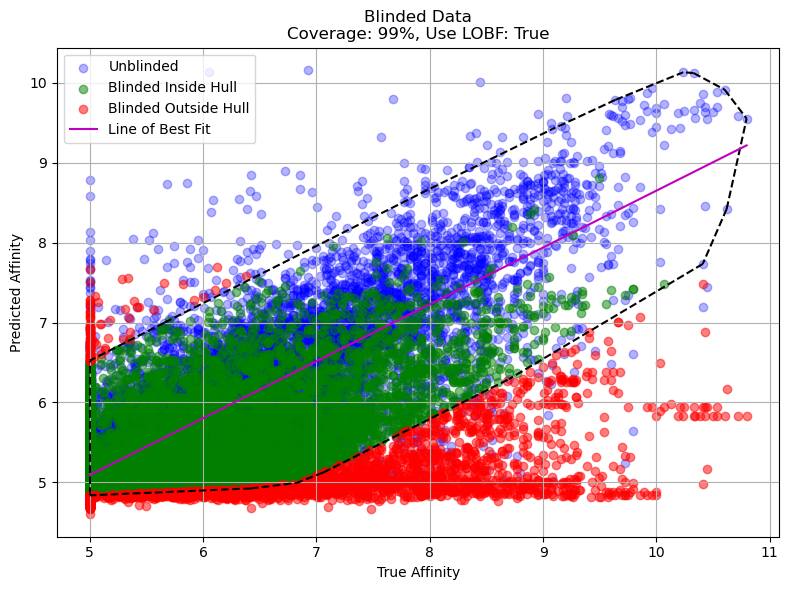

In [71]:
unblinded_file = "new/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "new/concatenated_final_test_predictions.csv"
pharos_file = "new/pharos_test_predictions_GINConvNet.csv"

unblinded = load_xy(unblinded_file)
blinded = load_xy(blinded_file)
pharos = load_xy(pharos_file)

coverages = [0.99]

print("CHR Metrics for Blinded Data:\n")
for cov in coverages:
    print(f"Coverage: {cov}")
    chr_result = compute_chr(unblinded, blinded, coverage=cov, use_lobf=True)
    for k, v in chr_result.items():
        print(f"  {k}: {v}")
    print("-" * 40)

    # Optional visualization
    plot_density_hull(unblinded, blinded, coverage=cov, use_lobf=True, title="Blinded Data")


Hull Distance Metrics:
  Average deviation distance: 0.3312
  Average direction vector: [ 0.00900513 -0.32664667]
  Magnitude of average direction (coherence): 0.3268
LOBF Distance Metrics:
  Average deviation distance: 1.2115
  Average direction vector: [-0.70018759  0.98412299]
  Magnitude of average direction (coherence): 1.2078


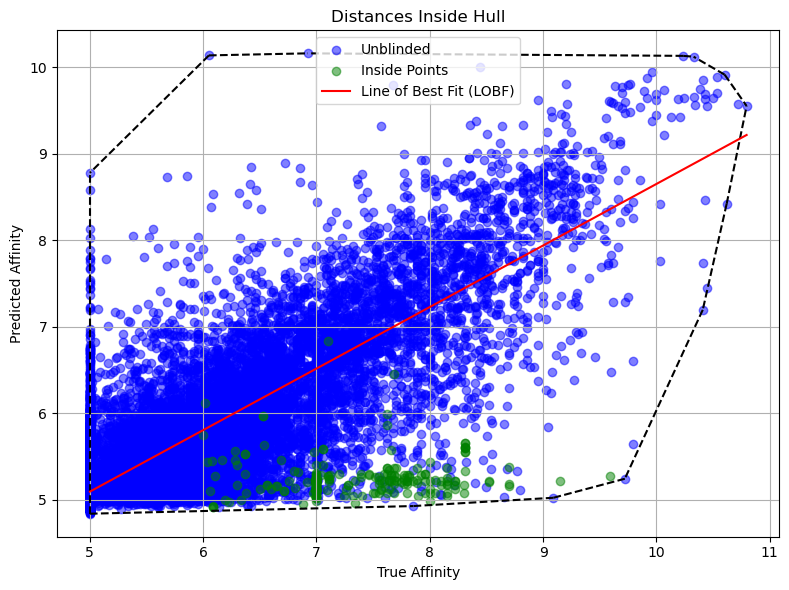

In [72]:
inside_distances_hull, inside_distances_lobf, inside_points, hull_boundary, lobf_line = compute_distances_inside_hull(unblinded, pharos)
plot_distances_inside_hull(unblinded, inside_points, inside_distances_hull, inside_distances_lobf, hull_boundary, lobf_line)


Characteristic Box

Conf int from lobf

CHR Metrics for Pharos Data:

Coverage: 0.99
  num_outliers: 184
  avg_deviation_distance: 0.49053107196417445
  avg_direction_vector: [-0.2352299  0.4155807]
  coherence_magnitude: 0.47753578328321766
----------------------------------------


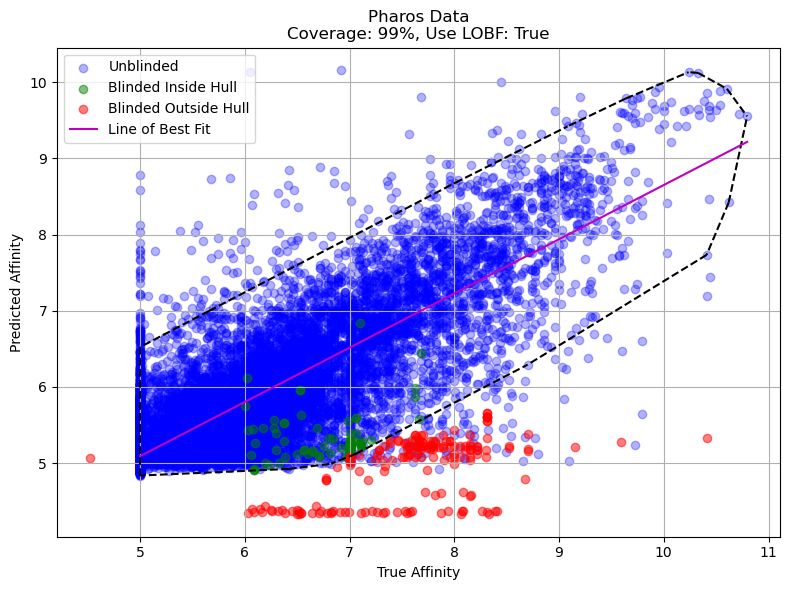

In [73]:
print("CHR Metrics for Pharos Data:\n")
for cov in coverages:
    print(f"Coverage: {cov}")
    chr_result = compute_chr(unblinded, pharos, coverage=cov, use_lobf=True)
    for k, v in chr_result.items():
        print(f"  {k}: {v}")
    print("-" * 40)

    # Optional visualization
    plot_density_hull(unblinded, pharos, coverage=cov, use_lobf=True, title="Pharos Data")


In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.covariance import EmpiricalCovariance
from scipy.stats import gaussian_kde
from scipy.spatial.distance import mahalanobis

# ---- Metrics ----

def knn_average_distance(blinded, unblinded, k=5):
    nbrs = NearestNeighbors(n_neighbors=k).fit(unblinded)
    distances, _ = nbrs.kneighbors(blinded)
    return np.mean(distances, axis=1)

def kde_density_estimate(blinded, unblinded):
    kde = gaussian_kde(unblinded.T)
    return kde(blinded.T)

def mahalanobis_distances(blinded, unblinded):
    cov = EmpiricalCovariance().fit(unblinded)
    mean = cov.location_
    cov_inv = np.linalg.inv(cov.covariance_)
    return np.array([mahalanobis(x, mean, cov_inv) for x in blinded])

def directional_coherence(blinded, unblinded, k=5):
    nbrs = NearestNeighbors(n_neighbors=k).fit(unblinded)
    _, indices = nbrs.kneighbors(blinded)
    coherence_scores = []
    avg_vectors = []
    for i, idx in enumerate(indices):
        local_neighbors = unblinded[idx]
        vectors = local_neighbors - blinded[i]
        avg_vec = np.mean(vectors, axis=0)
        avg_vectors.append(avg_vec)
        coherence_scores.append(np.linalg.norm(avg_vec))
    return np.array(coherence_scores), np.array(avg_vectors)

# ---- Compute All ----

def compute_cold_start_metrics(blinded, unblinded, k=5):
    knn_dist = knn_average_distance(blinded, unblinded, k)
    kde_vals = kde_density_estimate(blinded, unblinded)
    maha_dist = mahalanobis_distances(blinded, unblinded)
    coherence, avg_vectors = directional_coherence(blinded, unblinded, k)

    metrics = pd.DataFrame({
        "kNN Avg Distance": knn_dist,
        "KDE Density": kde_vals,
        "Mahalanobis Distance": maha_dist,
        "Direction Coherence": coherence
    })
    
    # Print the averages
    print("=== AVERAGE METRICS ===")
    for column in metrics.columns:
        mean_val = metrics[column].mean()
        print(f"{column}: {mean_val:.4f}")
    print("========================")

    return metrics, avg_vectors

# ---- Visualization Functions ----

def plot_kde_density(unblinded, blinded, kde_vals):
    plt.figure(figsize=(6,5))
    plt.scatter(unblinded[:, 0], unblinded[:, 1], c='gray', label='Unblinded', alpha=0.5)
    plt.scatter(blinded[:, 0], blinded[:, 1], c=kde_vals, cmap='viridis', label='Blinded (KDE)', edgecolor='k')
    plt.colorbar(label='Density')
    plt.title("KDE Density Estimate")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_mahalanobis_contour(unblinded, blinded, maha_vals):
    mean = np.mean(unblinded, axis=0)
    plt.figure(figsize=(6,5))
    plt.scatter(unblinded[:, 0], unblinded[:, 1], c='lightgray', label='Unblinded')
    plt.scatter(blinded[:, 0], blinded[:, 1], c=maha_vals, cmap='coolwarm', label='Blinded (Mahalanobis)', edgecolor='k')
    plt.colorbar(label='Mahalanobis Distance')
    plt.scatter(*mean, c='red', marker='x', label='Mean')
    plt.title("Mahalanobis Distance")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_knn_distance(unblinded, blinded, knn_vals):
    plt.figure(figsize=(6,5))
    plt.scatter(unblinded[:, 0], unblinded[:, 1], c='lightgray', label='Unblinded')
    plt.scatter(blinded[:, 0], blinded[:, 1], c=knn_vals, cmap='plasma', edgecolor='k', label='Blinded (kNN Dist)')
    plt.colorbar(label='Avg Distance to kNN')
    plt.title("kNN Average Distance")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_directional_vectors(blinded, avg_vectors):
    plt.figure(figsize=(6,5))
    plt.quiver(
        blinded[:, 0], blinded[:, 1],
        avg_vectors[:, 0], avg_vectors[:, 1],
        angles='xy', scale_units='xy', scale=1, color='blue', width=0.003
    )
    plt.scatter(blinded[:, 0], blinded[:, 1], c='red', label='Blinded')
    plt.title("Directional Coherence Vectors")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


=== AVERAGE METRICS ===
kNN Avg Distance: 0.0226
KDE Density: 2.3051
Mahalanobis Distance: 1.3398
Direction Coherence: 0.0151


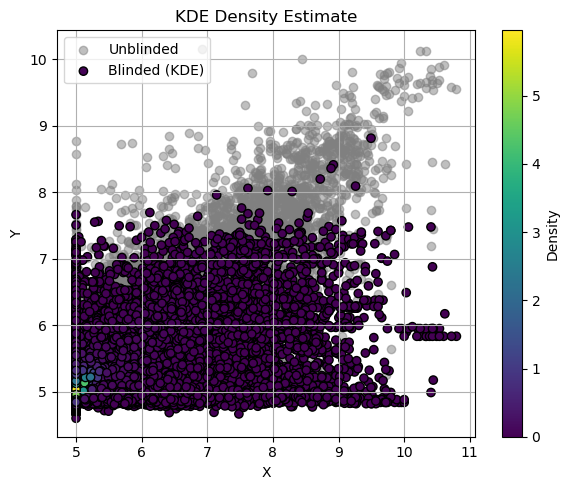

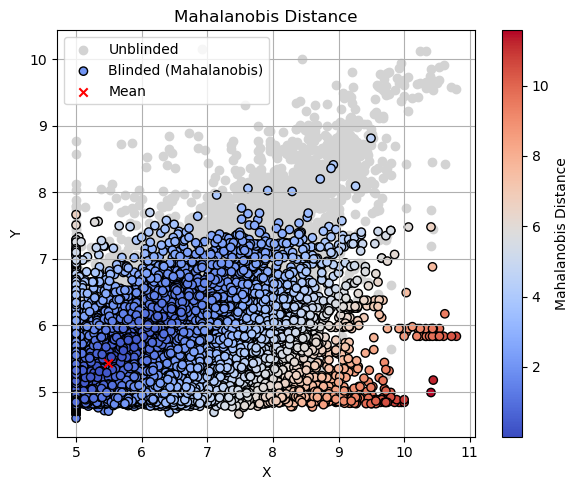

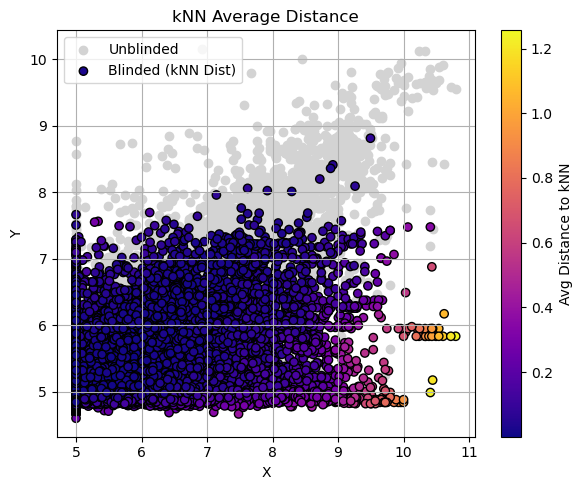

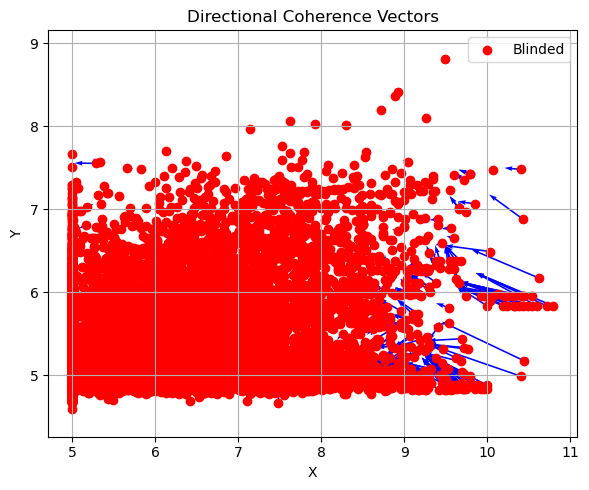

In [75]:
metrics, vectors = compute_cold_start_metrics(blinded, unblinded)

# Optional: Visualize
plot_kde_density(unblinded, blinded, metrics["KDE Density"])
plot_mahalanobis_contour(unblinded, blinded, metrics["Mahalanobis Distance"])
plot_knn_distance(unblinded, blinded, metrics["kNN Avg Distance"])
plot_directional_vectors(blinded, vectors)
